In [86]:
#########################
### Import Code Stuff ###
#########################

### Numpy and Scipy
import numpy as np
from scipy.stats import binned_statistic

### Pandas
import pandas as pd

### Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column, vstack

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

### Functions used in this code
import age_functions as afunc

### Other
import warnings
warnings.filterwarnings('ignore')

### Progress Bar
from tqdm import tqdm_notebook

In [93]:
###################
### Import Data ###
###################

gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = gcs[cln]

parsec = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parseclinage.fits',0)
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]


# supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
#                     names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
# supp2 = Table.from_pandas(supp2)

supp3 = pd.read_csv('../stx544_Supp/Table3.txt',comment='#',
                    names=['Name','[Fe/H]','Dist','Distupperr','Distlowerr','Av','Avuperr',
                           'Avlowerr','Y','Yuperr','Ylowerr','log(Age)','log(Age)uperr',
                           'log(Age)lowerr','Age(Gyr)','Age(Gyr)uperr','Age(Gyr)lowerr',
                           'RelativeAge'],sep='\s+')

supp3 = Table.from_pandas(supp3)

In [94]:
########################
### Xmatch NGC Names ###
########################

supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp2 = Table.from_pandas(supp2)

ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['Cluster'][i]=='M2'): 
        ngc_names.append('NGC7089')
        
    #M3: NGC5272
    elif (gcs['Cluster'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['Cluster'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['Cluster'][i]=='M5'): 
        ngc_names.append('NGC5904')
    
    #M10: NGC6254
    elif (gcs['Cluster'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M12: NGC6218
    elif (gcs['Cluster'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['Cluster'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M15: NGC7078
    elif (gcs['Cluster'][i]=='M15'): 
        ngc_names.append('NGC7078')
    
    #M19: NGC6273
    elif (gcs['Cluster'][i]=='M19'): 
        ngc_names.append('NGC6273')
    
    #M22: NGC6656
    elif (gcs['Cluster'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M53: NGC5024
    elif (gcs['Cluster'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M54: NGC6715
    elif (gcs['Cluster'][i]=='M54'): 
        ngc_names.append('NGC6715')
    
    #M55: NGC6809
    elif (gcs['Cluster'][i]=='M55'): 
        ngc_names.append('NGC6809')
        
    #M68: NGC4590
    elif (gcs['Cluster'][i]=='M68'): 
        ngc_names.append('NGC4590')   
    
    #M71: NGC6838
    elif (gcs['Cluster'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['Cluster'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #M92: NGC6341
    elif (gcs['Cluster'][i]=='M92'): 
        ngc_names.append('NGC5904')
    
    #M107: NGC6171
    elif (gcs['Cluster'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #47TUC: NGC0104
    elif (gcs['Cluster'][i]=='47Tuc'):
        ngc_names.append('NGC0104')
        
    #omegaCen: NGC5139
    elif (gcs['Cluster'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['Cluster'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

supp2 = supp2[s2_ind]
supp3 = supp3[s2_ind]
supp2['harris_dist'] = np.array([4.5,12.1,9.6,4.9,19.3,10.3,17.9,17.4,5.2,10.2,16.0,7.5,2.2,8.9,6.4,7.1,4.8,4.4,
                                 5.9,9.9,2.3,11.6,3.2,26.5,8.7,4.0,5.4,4.0,10.4,11.5])
supp2['harris_feh'] = np.array([-0.72,-1.18,-1.14,-1.59,-1.80,-2.23,-2.10,-2.27,-1.53,-1.50,-1.98,-1.29,-1.16,
                                -1.76,-1.02,-1.53,-1.37,-1.56,-0.45,-0.55,-2.02,-0.46,-1.70,-1.49,-1.10,-1.54,
                                -1.94,-0.78,-2.37,-1.65])

harris_ebv = np.array([0.04,0.02,0.22,0.24,0.02,0.05,0.02,0.01,0.12,0.01,0.00,0.03,0.35,0.36,0.33,0.02,0.19,0.28,
                       0.54,0.37,0.18,0.47,0.34,0.15,0.05,0.04,0.08,0.25,0.10,0.06])

#see extinction notebook for more
#ak/av = 0.11435794439099066
#e(j-k)/av = 0.1789622996970605

supp2['harris_ejk'] = harris_ebv*0.523927394130361
supp2['harris_ak'] = harris_ebv*0.4555635537199514  #*0.24360996634482945

In [95]:
np.unique(ngc_names)

array(['NGC0104', 'NGC1851', 'NGC1904', 'NGC2808', 'NGC288', 'NGC3201',
       'NGC362', 'NGC4147', 'NGC4590', 'NGC5024', 'NGC5053', 'NGC5139',
       'NGC5272', 'NGC5466', 'NGC5904', 'NGC6121', 'NGC6144', 'NGC6171',
       'NGC6205', 'NGC6218', 'NGC6229', 'NGC6254', 'NGC6273', 'NGC6293',
       'NGC6304', 'NGC6316', 'NGC6388', 'NGC6397', 'NGC6441', 'NGC6522',
       'NGC6544', 'NGC6569', 'NGC6642', 'NGC6656', 'NGC6715', 'NGC6723',
       'NGC6752', 'NGC6760', 'NGC6809', 'NGC6838', 'NGC7078', 'NGC7089',
       'Pal5', 'Pal6', 'Pismis26', 'Terzan9', 'Ton1'], dtype='<U8')

In [97]:
# np.unique(supp2['Cluster'])

In [16]:
from dlnpyutils import utils as dln

help(dln.interp)

Help on function interp in module dlnpyutils.utils:

interp(x, y, xout, kind='cubic', bounds_error=False, assume_sorted=True, extrapolate=True, exporder=2, fill_value=nan)
    # Interpolation with extrapolation



In [24]:
### NGC 3201
clus = np.where(ngc_names=='NGC3201')
n3201 = gcs[clus]

s2=supp2[np.where(supp2['Cluster']=='NGC3201')]
s3=supp3[np.where(supp3['Name']=='NGC3201')]

In [36]:
feh_3201 = dln.closest(parsec['MH'],s2['[Fe/H]'].data)
age_3201 = dln.closest(parsec['logAge'],np.log10(s2['Age']**9).data)

iso_3201 = parsec[np.where((parsec['logAge']==age_3201[0])&(parsec['MH']==feh_3201[0]))]

In [40]:
jk_3201 = iso_3201['Jmag'] - iso_3201['Ksmag'] - s2['harris_ejk'] + s2['Dist']
k_3201 = iso_3201['Ksmag'] - s2['harris_ak']

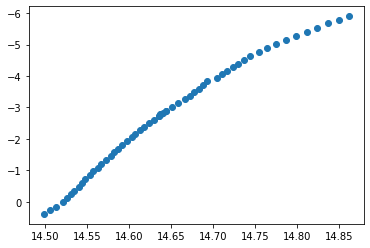

In [42]:
plt.scatter(jk_3201,k_3201)
plt.gca().invert_yaxis()

In [44]:
help(dln.interp)

Help on function interp in module dlnpyutils.utils:

interp(x, y, xout, kind='cubic', bounds_error=False, assume_sorted=True, extrapolate=True, exporder=2, fill_value=nan)
    # Interpolation with extrapolation



In [74]:
ind_sort = jk_3201.argsort()
k_3201_sort = k_3201[ind_sort][::2]
jk_3201_sort = jk_3201[ind_sort][::2]

In [75]:
np.diff(jk_3201_sort)

array([0.014, 0.013, 0.008, 0.01 , 0.009, 0.01 , 0.01 , 0.009, 0.01 ,
       0.011, 0.01 , 0.011, 0.011, 0.002, 0.003, 0.004, 0.014, 0.015,
       0.01 , 0.01 , 0.018, 0.013, 0.013, 0.018, 0.02 , 0.024, 0.024,
       0.027])

In [47]:
np.linspace(min(jk_3201),max(k_3201))

array([14.49925743, 14.21126574, 13.92327405, 13.63528236, 13.34729068,
       13.05929899, 12.7713073 , 12.48331561, 12.19532393, 11.90733224,
       11.61934055, 11.33134886, 11.04335718, 10.75536549, 10.4673738 ,
       10.17938212,  9.89139043,  9.60339874,  9.31540705,  9.02741537,
        8.73942368,  8.45143199,  8.1634403 ,  7.87544862,  7.58745693,
        7.29946524,  7.01147356,  6.72348187,  6.43549018,  6.14749849,
        5.85950681,  5.57151512,  5.28352343,  4.99553174,  4.70754006,
        4.41954837,  4.13155668,  3.84356499,  3.55557331,  3.26758162,
        2.97958993,  2.69159825,  2.40360656,  2.11561487,  1.82762318,
        1.5396315 ,  1.25163981,  0.96364812,  0.67565643,  0.38766475])

In [57]:
np.diff(jk_3201)

array([ 0.007,  0.007,  0.008,  0.005,  0.005,  0.003,  0.006,  0.004,
        0.004,  0.005,  0.004,  0.006,  0.004,  0.006,  0.005,  0.004,
        0.005,  0.005,  0.005,  0.006,  0.004,  0.006,  0.005,  0.006,
        0.006,  0.005,  0.005,  0.004, -0.006, -0.003,  0.002,  0.007,
        0.007,  0.007,  0.008,  0.007,  0.004,  0.006,  0.005,  0.005,
        0.012,  0.006,  0.006,  0.007,  0.006,  0.007,  0.007,  0.011,
        0.009,  0.011,  0.012,  0.012,  0.013,  0.011,  0.014,  0.013,
        0.011])

In [58]:
jk_3201

array([14.49925743, 14.50625743, 14.51325743, 14.52125743, 14.52625743,
       14.53125743, 14.53425743, 14.54025743, 14.54425743, 14.54825743,
       14.55325743, 14.55725743, 14.56325743, 14.56725743, 14.57325743,
       14.57825743, 14.58225743, 14.58725743, 14.59225743, 14.59725743,
       14.60325743, 14.60725743, 14.61325743, 14.61825743, 14.62425743,
       14.63025743, 14.63525743, 14.64025743, 14.64425743, 14.63825743,
       14.63525743, 14.63725743, 14.64425743, 14.65125743, 14.65825743,
       14.66625743, 14.67325743, 14.67725743, 14.68325743, 14.68825743,
       14.69325743, 14.70525743, 14.71125743, 14.71725743, 14.72425743,
       14.73025743, 14.73725743, 14.74425743, 14.75525743, 14.76425743,
       14.77525743, 14.78725743, 14.79925743, 14.81225743, 14.82325743,
       14.83725743, 14.85025743, 14.86125743])

In [73]:
dln.interp(jk_3201_sort[::2],k_3201_sort[::2],np.linspace(14.50,14.85))

array([ 3.72941222e-01,  2.48812087e-01,  1.34667293e-01, -4.55364406e-04,
       -1.86626285e-01, -3.96900185e-01, -5.71578901e-01, -7.59854470e-01,
       -9.44924345e-01, -1.11342436e+00, -1.28579829e+00, -1.47311587e+00,
       -1.65710501e+00, -1.82259853e+00, -1.97607679e+00, -2.13288583e+00,
       -2.29715705e+00, -2.45106945e+00, -2.55912344e+00, -2.73027003e+00,
       -2.85327254e+00, -2.99870065e+00, -3.11945718e+00, -3.22282500e+00,
       -3.33573663e+00, -3.48767862e+00, -3.66477242e+00, -3.82488768e+00,
       -3.93090623e+00, -4.00957286e+00, -4.10574760e+00, -4.23144803e+00,
       -4.35987232e+00, -4.48013690e+00, -4.59485051e+00, -4.70318623e+00,
       -4.80256120e+00, -4.89240285e+00, -4.97591548e+00, -5.05665851e+00,
       -5.13657366e+00, -5.21582553e+00, -5.29448759e+00, -5.37248882e+00,
       -5.44933387e+00, -5.52444988e+00, -5.59726398e+00, -5.66720330e+00,
       -5.73369497e+00, -5.79616614e+00])

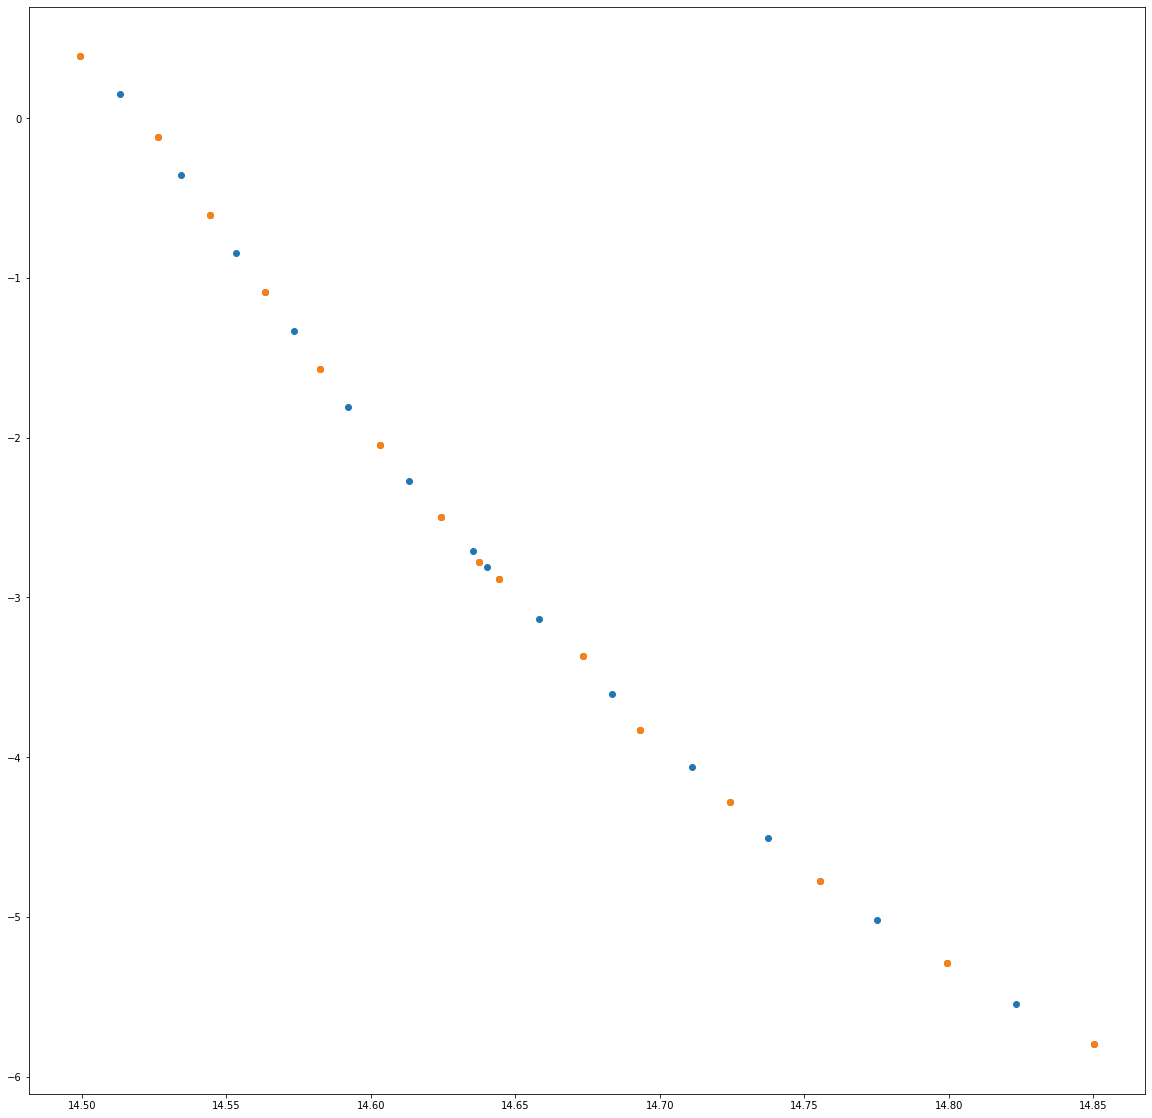

In [150]:
plt.figure(figsize=[20,20])
plt.scatter(jk_3201_sort,k_3201_sort)
plt.scatter(jk_3201_sort[::2],k_3201_sort[::2])

In [152]:
##########################
### Pick Out Isochrone ###
##########################

uniq_supp2 = np.unique(supp2['Cluster'])
isos_cols = []
isos_kmag = []

for i in uniq_supp2:
    s2_clus = supp2[np.where(supp2['Cluster']==i)]
    s3_clus = supp3[np.where(supp3['Name']==i)]
    
    feh_clus = dln.closest(parsec['MH'],s2_clus['[Fe/H]'].data)
    age_clus = dln.closest(parsec['logAge'],np.log10(s2_clus['Age']**9).data)
    
    iso = parsec[np.where((parsec['logAge']==age_clus[0])&(parsec['MH']==feh_clus[0]))]

    color = iso['Jmag'] - iso['Ksmag']
    mags = iso['Ksmag']
    
    isos_cols.append(color)
    isos_kmag.append(mags)
    
isos_cols = np.asarray(isos_cols)
isos_kmag = np.asarray(isos_kmag)

In [183]:
#############################
### Isochrone Differences ###
#############################

diffs = []
for i in range(len(isos_cols)):
    
    # 
    clus = np.where(ngc_names==uniq_supp2[i])
    s2_clus = np.where(supp2['Cluster']==uniq_supp2[i])
    
    # sort values
    ind_sort = isos_cols[i].argsort()
    cols_sort = np.asarray(isos_cols[i][ind_sort][::2])
    kmag_sort = np.asarray(isos_kmag[i][ind_sort][::2])
    
#     print(np.median((gcs['J']-gcs['K'])[clus]))
#     print(cols_sort)
#     print(kmag_sort)
    
#     k_iso = dln.interp(cols_sort,kmag_sort,)
    #+supp2['Dist'][s2_clus]
    #-supp2['Av'][s2_clus]*0.1789622996970605).data
    #-supp2['Av'][s2_clus]*0.11435794439099066).data

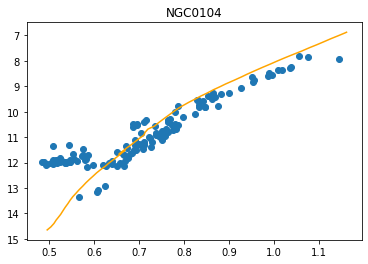

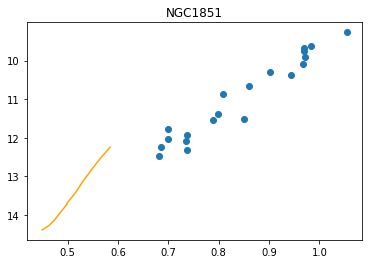

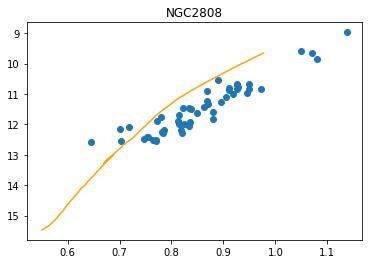

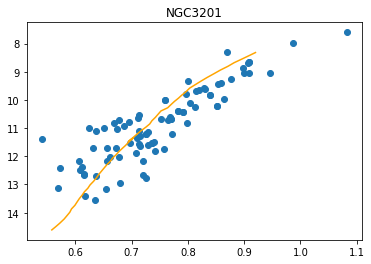

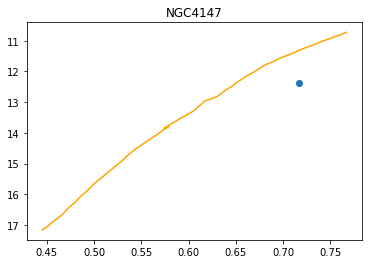

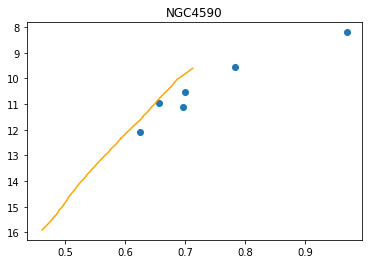

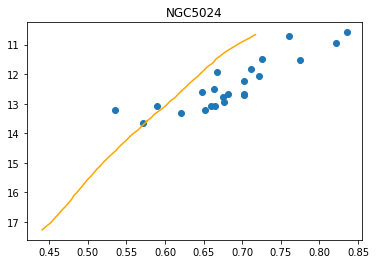

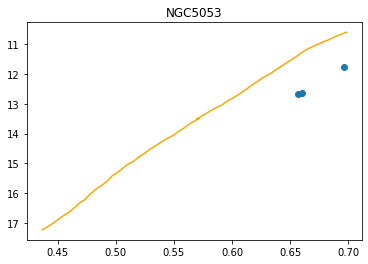

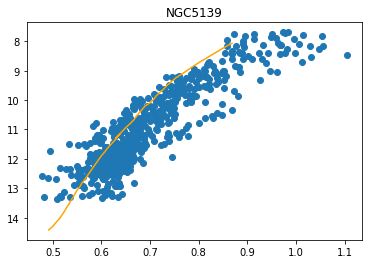

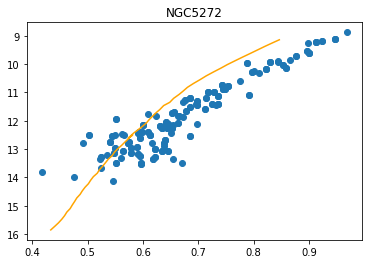

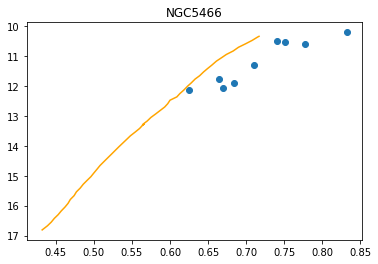

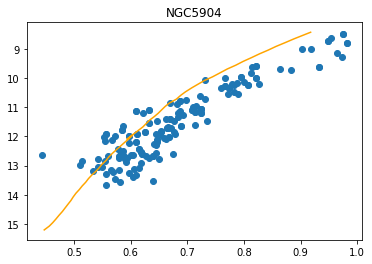

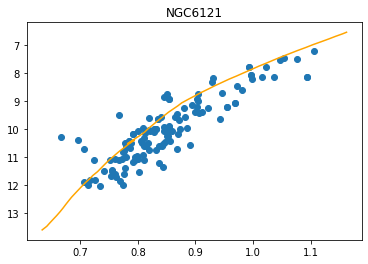

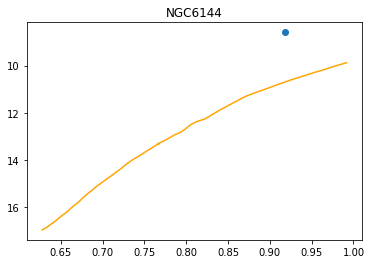

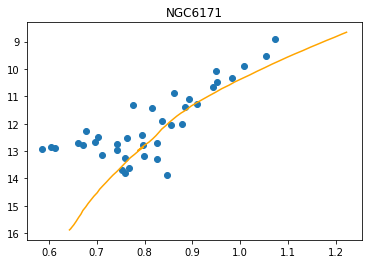

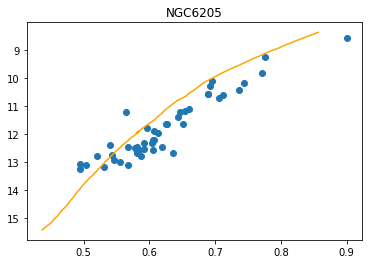

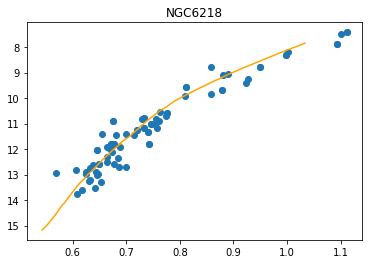

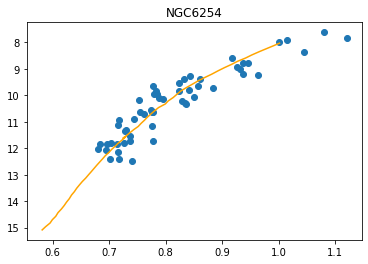

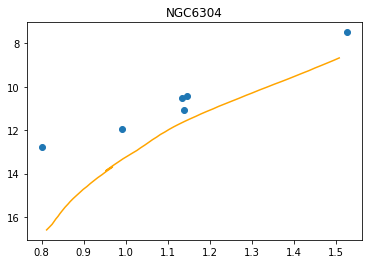

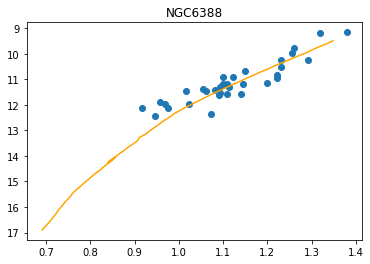

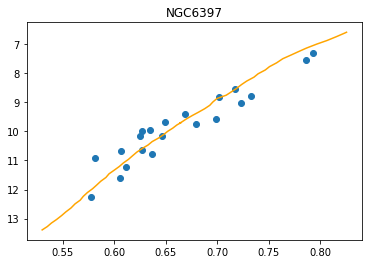

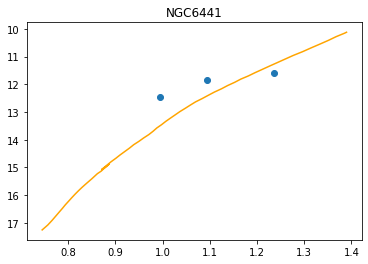

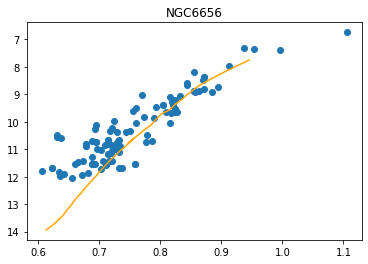

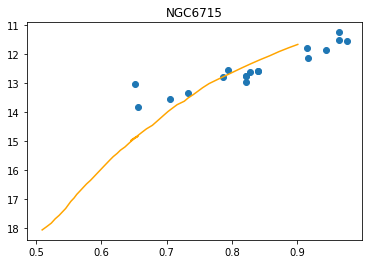

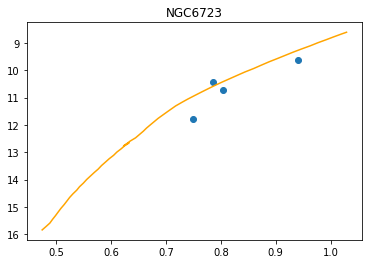

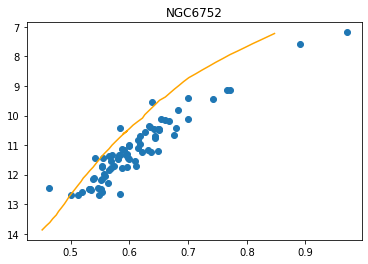

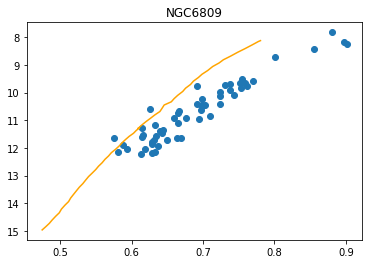

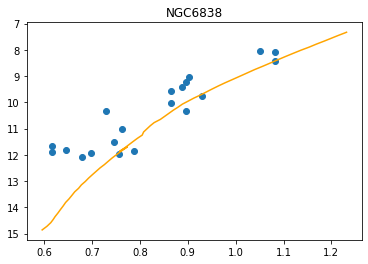

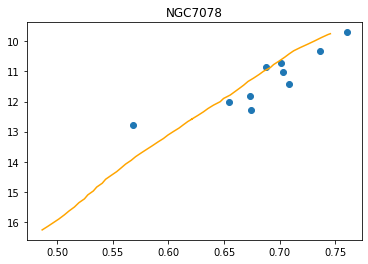

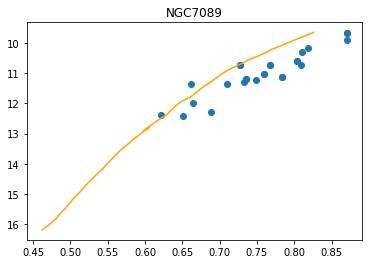

In [167]:
for i in range(len(uniq_supp2)):
    clus = np.where(ngc_names==uniq_supp2[i])
    s2_clus = np.where(supp2['Cluster']==uniq_supp2[i])
    plt.figure()
    
    plt.scatter((gcs['J']-gcs['K'])[clus],gcs['K'][clus])
    
    plt.plot(isos_cols[i]+supp2['Av'][s2_clus]*0.1789622996970605,
             isos_kmag[i]+supp2['Dist'][s2_clus]-supp2['Av'][s2_clus]*0.11435794439099066,c='orange')
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}'.format(uniq_supp2[i]))
    
    plt.show()

In [103]:
ind_sort = jk_3201.argsort()
k_3201_sort = k_3201[ind_sort][::2]
jk_3201_sort = jk_3201[ind_sort][::2]

[array([3.7248, 3.7225, 3.7202, 3.7182, 3.7169, 3.7155, 3.7139, 3.7123,
        3.7105, 3.7088, 3.707 , 3.7051, 3.7032, 3.7011, 3.6991, 3.697 ,
        3.695 , 3.6928, 3.6906, 3.6884, 3.6862, 3.6839, 3.6817, 3.6795,
        3.6775, 3.6768, 3.6781, 3.6802, 3.6804, 3.6781, 3.6755, 3.6729,
        3.6703, 3.6677, 3.665 , 3.6624, 3.6596, 3.6569, 3.6542, 3.6514,
        3.6486, 3.6459, 3.6431, 3.6402, 3.6374, 3.6345, 3.6317, 3.6288,
        3.626 , 3.6224, 3.6196, 3.6167, 3.6131, 3.6095, 3.6067, 3.6031,
        3.5995, 3.596 , 3.5925, 3.589 , 3.5854, 3.5819, 3.5784, 3.5748,
        3.5713, 3.5677, 3.5642, 3.5608, 3.5598]),
 array([3.7392, 3.7348, 3.731 , 3.728 , 3.7254, 3.723 , 3.7225, 3.7206,
        3.7202, 3.7193, 3.7171, 3.7149, 3.7126, 3.7103, 3.708 , 3.7056,
        3.7029, 3.7003, 3.6979, 3.6954, 3.6944]),
 array([3.7416, 3.7372, 3.7345, 3.7324, 3.7304, 3.7285, 3.7265, 3.7245,
        3.7223, 3.7204, 3.7185, 3.7167, 3.7147, 3.7128, 3.7107, 3.7081,
        3.706 , 3.7038, 3.7017, 3.69

In [86]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [87]:
lits_isos = []
exts = []
harris_exts = []
harris_reds = []
clus_feh_apo = []
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    clus_feh_med = np.median(gcs['FE_H'][clus])
    clus_feh_apo.append(clus_feh_med)
    age = np.log10(supp2['Age'][i]*10**9)
    
    exts.append(gcs['Ejk_med'][clus])
    
    harris_exts.append(supp2['harris_ak'][i]*np.ones(len(gcs[clus])))
    harris_reds.append(supp2['harris_ejk'][i]*np.ones(len(gcs[clus])))
    
    lits_isos.append(parsec[np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                                     (parsec['MH']==closest(clus_feh_med,parsec['MH'])))])
    

In [88]:
# dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.

# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#     plt.figure(figsize=[8,8])
#     plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}: harris dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
    
#     plt.show()
    


In [89]:
# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#     plt.figure(figsize=[8,8])
#     plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+supp2['Dist'][i])
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}: paper chris sent dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
    
#     plt.show()

In [90]:
# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#     dismod = 5.*np.log10(gcs['distmed'][clus]*1000)-5
    
#     plt.figure(figsize=[8,8])
#     plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-dismod*0.99)
#     plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}: gcs dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
    
#     plt.show()

In [91]:
dismod = 5.*np.log10(supp2['harris_dist']*1000)-5.

lits_isos_feh = []
harris_isos_feh = []

for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    clus_feh_med = supp2['[Fe/H]'][i]
    harris_feh = supp2['harris_feh'][i]
    age = np.log10(supp2['Age'][i]*10**9)
    
    lits_isos_feh.append(parsec[np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                                     (parsec['MH']==closest(clus_feh_med,parsec['MH'])))])
    harris_isos_feh.append(parsec[np.where((parsec['logAge']==closest(age,parsec['logAge']))&
                                     (parsec['MH']==closest(harris_feh,parsec['MH'])))])


# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#     plt.figure(figsize=[8,8])
#     plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     plt.scatter(lits_isos_feh[i]['Jmag']-lits_isos_feh[i]['Ksmag'],lits_isos_feh[i]['Ksmag']+dismod[i])
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}: harris dist, feh paper sent, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
    
#     plt.show()
    
# print('#####################################################################################################')
    
# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#     plt.figure(figsize=[8,8])
#     plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     plt.scatter(harris_isos_feh[i]['Jmag']-harris_isos_feh[i]['Ksmag'],harris_isos_feh[i]['Ksmag']+dismod[i])
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}: harris dist, feh harris, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
    
#     plt.show()

In [92]:
# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#     dismod = 5.*np.log10(gcs['D1_med'][clus]*1000)-5
    
#     plt.figure(figsize=[8,8])
#     plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-dismod*0.99)
#     plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
    
#     plt.gca().invert_yaxis()
    
#     plt.title(r'{}: ARA dist, gcs feh, age paper sent, gcs ejk/1.5'.format(supp2['Cluster'][i]))
#     plt.xlabel(r'J - K')
#     plt.ylabel(r'K')
    
#     plt.show()

In [93]:
### ARA Distances

def d2mu(distance):
    '''Convert distance to distance modulus'''
    return 5.*np.log10(distance) - 5.

def mu2d(mu):
    '''convert distance modulus to distance'''
    return 10**((1/5)*(mu+5))


In [94]:
dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.

### Medians and Offsets
first_col = []
first_med_gcs = []
first_med_iso = []
second_col = []
second_med_gcs = []
second_med_iso = []
third_col = []
third_med_gcs = []
third_med_iso = []
fourth_col = []
fourth_med_gcs = []
fourth_med_iso = []
fifth_col = []
fifth_med_gcs = []
fifth_med_iso = []
sixth_col = []
sixth_med_gcs = []
sixth_med_iso = []
seventh_col = []
seventh_med_gcs = []
seventh_med_iso = []
eighth_col = []
eighth_med_gcs = []
eighth_med_iso = []

###
med_g = []
med_f = []

for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    med_g.append(np.median(gcs['logg'][clus]))
    med_f.append(np.median(gcs['FE_H'][clus]))
    
    ### first column
    first_med = np.median((gcs['K'][clus]-harris_exts[i]))-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    first_col.append(first_med)
    first_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])))
    first_med_iso.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]))
    
    ### second column
    second_med = np.median((gcs['K'][clus]-harris_exts[i]))-np.median(lits_isos[i]['Ksmag']+dismod1[i]*0.975)
    second_col.append(second_med)
    second_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])))
    second_med_iso.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]*0.975))
    
    
    ### third column
    third_med = np.median((gcs['K'][clus]-harris_exts[i]))-np.median(lits_isos[i]['Ksmag']+supp2['Dist'][i])
    third_col.append(third_med)
    third_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])))
    third_med_iso.append(np.median(lits_isos[i]['Ksmag']+supp2['Dist'][i]))
    
    ### fourth column
    fourth_med = np.median((gcs['K'][clus]-harris_exts[i])) - np.median(lits_isos_feh[i]['Ksmag']+dismod1[i])
    fourth_col.append(fourth_med)
    fourth_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])))
    fourth_med_iso.append(np.median(lits_isos_feh[i]['Ksmag']+dismod1[i]))
    
    ### fifth column
    dmod = 5.*np.log10(gcs['distmed'][clus]*1000)-5.
    fifth_med = np.median((gcs['K'][clus]-harris_exts[i])-dmod)-np.median(lits_isos[i]['Ksmag'])
    fifth_col.append(fifth_med)
    fifth_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])-dmod))
    fifth_med_iso.append(np.median(lits_isos[i]['Ksmag']))
    
    ### sixth column
    ara_mu = -1.2628 + 1.0844*d2mu(gcs['D1_med'][clus]*1000.)
    sixth_med = np.median((gcs['K'][clus]-harris_exts[i])-ara_mu)-np.median(lits_isos[i]['Ksmag'])
    sixth_col.append(sixth_med)
    sixth_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])-ara_mu))
    sixth_med_iso.append(np.median(lits_isos[i]['Ksmag']))
    
    ### seventh column
    seventh_med = np.median((gcs['K'][clus]-harris_exts[i]))-np.median(harris_isos_feh[i]['Ksmag']+
                                                                           dismod1[i])
    seventh_col.append(seventh_med)
    seventh_med_gcs.append(np.median((gcs['K'][clus]-harris_exts[i])))
    seventh_med_iso.append(np.median(harris_isos_feh[i]['Ksmag']+dismod1[i]))
    
    ### eighth column
    eighth_med = np.median((gcs['K']-gcs['AK_TARG'])[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    eighth_col.append(eighth_med)
    eighth_med_gcs.append(np.median((gcs['K']-gcs['AK_TARG'])[clus]))
    eighth_med_iso.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]))


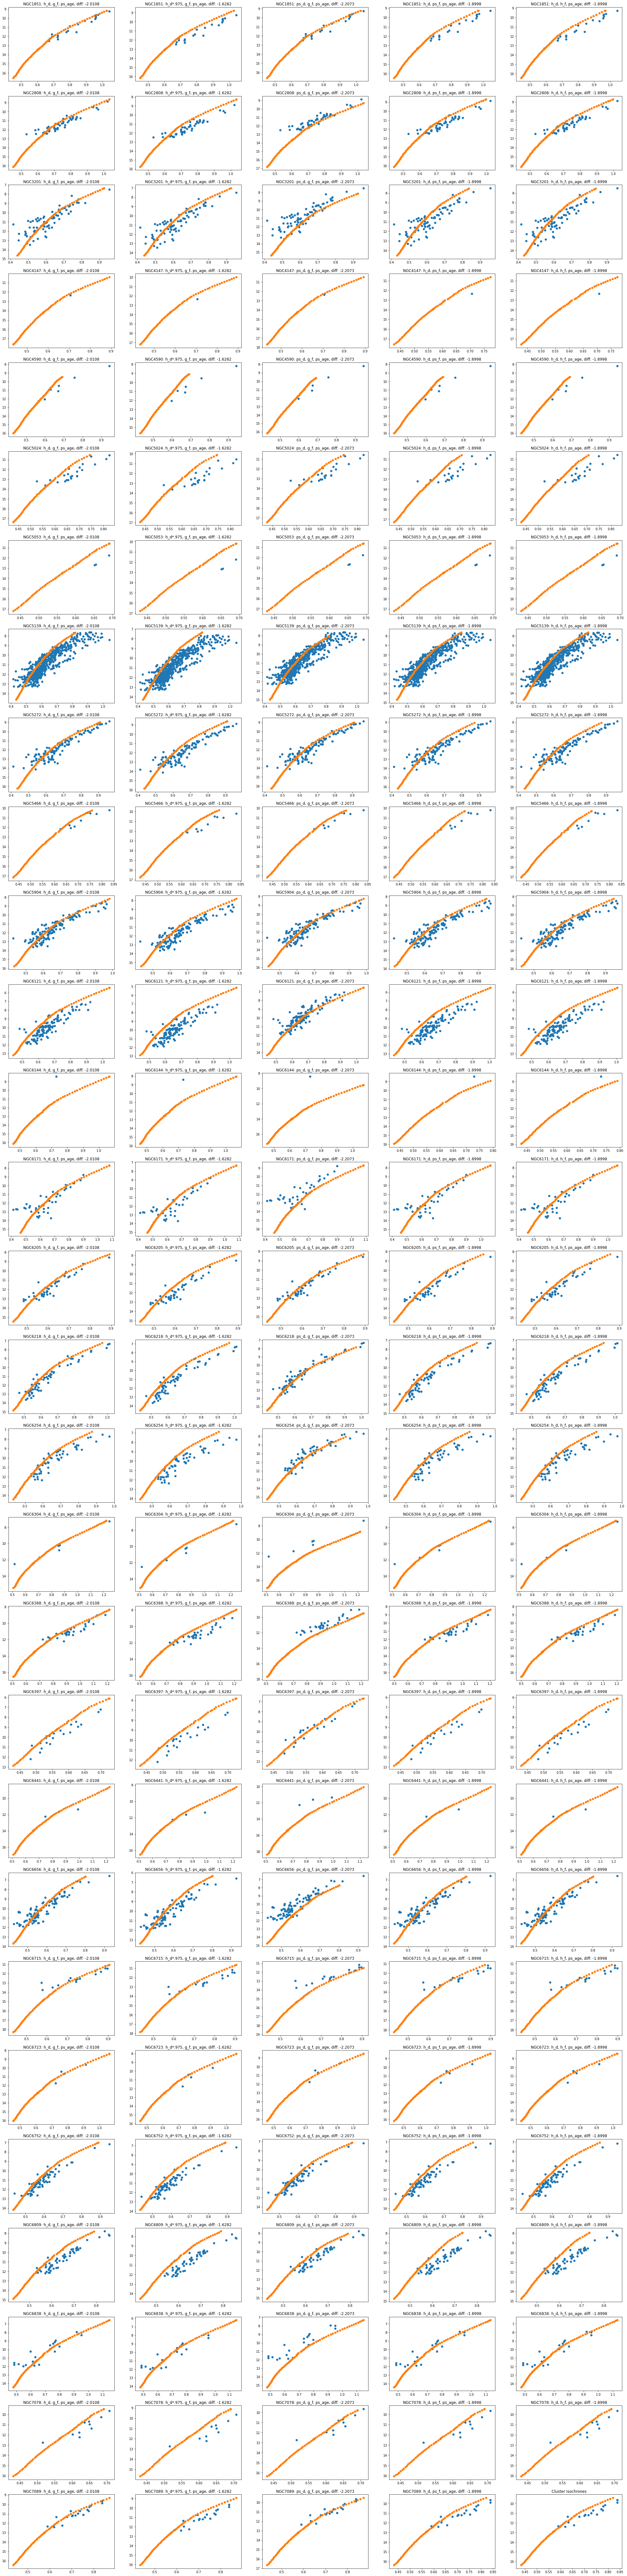

In [95]:
f=0#0.05
fig,ax=plt.subplots(29,5,figsize=[35,150])
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    ### first column
    ax[i][0].scatter((gcs['J']-gcs['K'])[clus]-supp2['harris_ejk'][i]-f,gcs['K'][clus]-supp2['harris_ak'][i])
    ax[i][0].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    
    ax[i][0].invert_yaxis()
    ax[i][0].set_title(r'{}: h_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],first_med))
    
    ### second column
    ax[i][1].scatter((gcs['J']-gcs['K'])[clus]-supp2['harris_ejk'][i]-f,gcs['K'][clus]-supp2['harris_ak'][i])
    ax[i][1].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]*0.975)
    
    ax[i][1].invert_yaxis()
    ax[i][1].set_title(r'{}: h_d*.975, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],second_med))
    
    ### third column
    ax[i][2].scatter((gcs['J']-gcs['K'])[clus]-supp2['harris_ejk'][i]-f,gcs['K'][clus]-supp2['harris_ak'][i])
    ax[i][2].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+supp2['Dist'][i])
    
    ax[i][2].invert_yaxis()
    ax[i][2].set_title(r'{}: ps_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],third_med))
    
    ### fourth column
    ax[i][3].scatter((gcs['J']-gcs['K'])[clus]-supp2['harris_ejk'][i]-f,gcs['K'][clus]-supp2['harris_ak'][i])
    ax[i][3].scatter(lits_isos_feh[i]['Jmag']-lits_isos_feh[i]['Ksmag'],lits_isos_feh[i]['Ksmag']+dismod1[i])
    
    ax[i][3].invert_yaxis()
    ax[i][3].set_title(r'{}: h_d, ps_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],fourth_med))
    
#     ### fifth column
#     dmod = 5.*np.log10(gcs['distmed'][clus]*1000)-5.
#     ax[i][4].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-dmod)
#     ax[i][4].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
    
#     ax[i][4].invert_yaxis()
#     ax[i][4].set_title(r'{}: d_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],fifth_med))
    
#     ### sixth column
#     ara_mu = -1.2628 + 1.0844*d2mu(gcs['D1_med'][clus]*1000.)
#     ax[i][5].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus]-ara_mu)
#     ax[i][5].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag'])
    
#     ax[i][5].invert_yaxis()
#     ax[i][5].set_title(r'{}: a_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],sixth_med))
    
    ### seventh column
    ax[i][4].scatter((gcs['J']-gcs['K'])[clus]-supp2['harris_ejk'][i]-f,gcs['K'][clus]-supp2['harris_ak'][i])
    ax[i][4].scatter(harris_isos_feh[i]['Jmag']-harris_isos_feh[i]['Ksmag'],
                     harris_isos_feh[i]['Ksmag']+dismod1[i])

    ax[i][4].invert_yaxis()
    ax[i][4].set_title(r'{}: h_d, h_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],seventh_med))
    
#     ### eighth column
#     ax[i][7].scatter((gcs['J']-gcs['K']-1.5*gcs['AK_TARG'])[clus],(gcs['K']-gcs['AK_TARG'])[clus])
#     ax[i][7].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    
#     ax[i][7].invert_yaxis()
#     ax[i][7].set_title(r'{}: h_d, g_f, ps_age, ext_ak, diff: {:.4f}'.format(supp2['Cluster'][i],eighth_med))

plt.title(r'Cluster Isochrones')
# plt.savefig('clusterisochrones.pdf',bbox_inches='tight',dpi=300)    
plt.show()

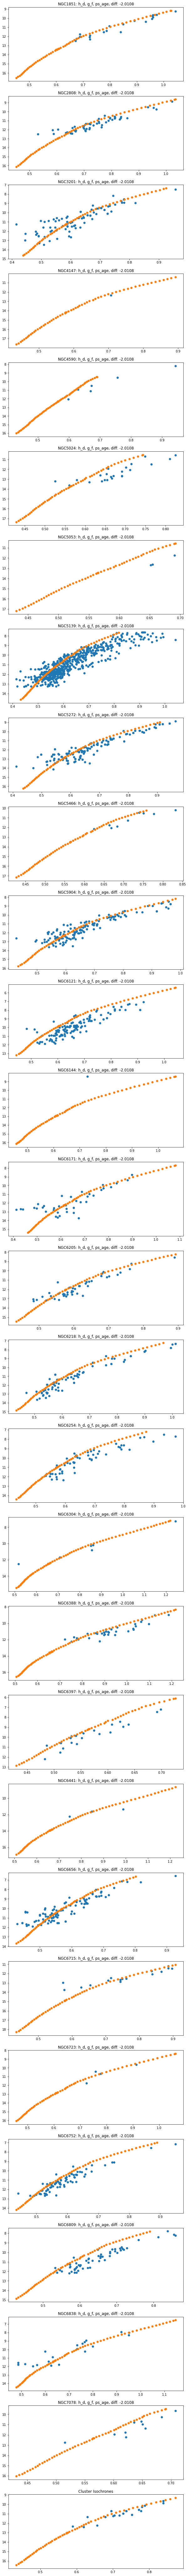

In [96]:
fig,ax=plt.subplots(29,1,figsize=[10,150])
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    ### first column
    ax[i].scatter((gcs['J']-gcs['K'])[clus]-supp2['harris_ejk'][i],gcs['K'][clus]-supp2['harris_ak'][i])
    ax[i].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    
    ax[i].invert_yaxis()
    ax[i].set_title(r'{}: h_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],first_med))

plt.title(r'Cluster Isochrones')   
plt.show()

# rm APOGEE Derived Distances

In [21]:
# fig,ax=plt.subplots(29,6,figsize=[40,150])
# for i in range(len(supp2)):
#     clus = np.where(ngc_names==supp2['Cluster'][i])
    
#    ### first column
#     ax[i][0].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     ax[i][0].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    
#     ax[i][0].invert_yaxis()
#     ax[i][0].set_title(r'{}: h_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],first_med))
    
#     ### second column
#     ax[i][1].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     ax[i][1].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]*0.975)
    
#     ax[i][1].invert_yaxis()
#     ax[i][1].set_title(r'{}: h_d*.975, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],second_med))
    
#     ### third column
#     ax[i][2].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     ax[i][2].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+supp2['Dist'][i])
    
#     ax[i][2].invert_yaxis()
#     ax[i][2].set_title(r'{}: ps_d, g_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],third_med))
    
#     ### fourth column
#     ax[i][3].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     ax[i][3].scatter(lits_isos_feh[i]['Jmag']-lits_isos_feh[i]['Ksmag'],lits_isos_feh[i]['Ksmag']+dismod1[i])
    
#     ax[i][3].invert_yaxis()
#     ax[i][3].set_title(r'{}: h_d, ps_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],fourth_med))
    
#     ### seventh column
#     ax[i][4].scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
#     ax[i][4].scatter(harris_isos_feh[i]['Jmag']-harris_isos_feh[i]['Ksmag'],
#                      harris_isos_feh[i]['Ksmag']+dismod1[i])

#     ax[i][4].invert_yaxis()
#     ax[i][4].set_title(r'{}: h_d, h_f, ps_age, diff: {:.4f}'.format(supp2['Cluster'][i],seventh_med))
    
#     ### eighth column
#     ax[i][5].scatter((gcs['J']-gcs['K']-1.5*gcs['AK_TARG'])[clus],(gcs['K']-gcs['AK_TARG'])[clus])
#     ax[i][5].scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
#     eighth_med = np.median((gcs['K']-gcs['AK_TARG'])[clus])-np.median(lits_isos[i]['Ksmag']+dismod1[i])
    
#     ax[i][5].invert_yaxis()
#     ax[i][5].set_title(r'{}: h_d, g_f, ps_age, ext_ak, diff: {:.4f}'.format(supp2['Cluster'][i],eighth_med))
    
# plt.title(r'Cluster Isochrones rm APOGEE Distances')
# plt.savefig('clusterisochrones_rmapogee.pdf',bbox_inches='tight',dpi=300)    
# plt.show()

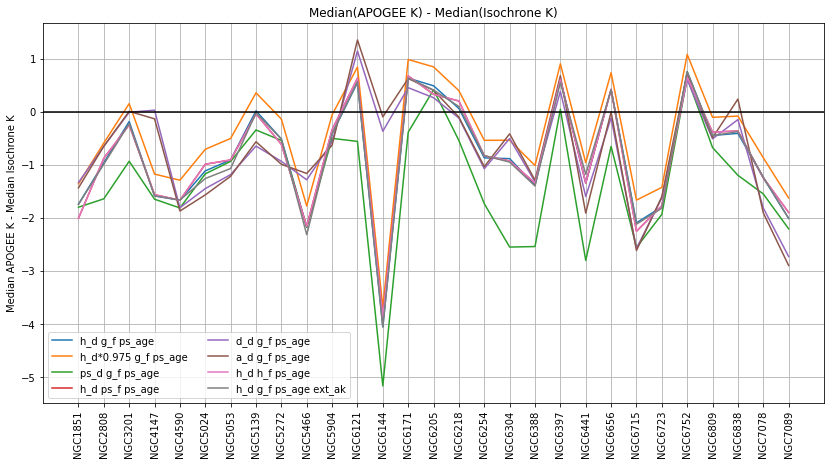

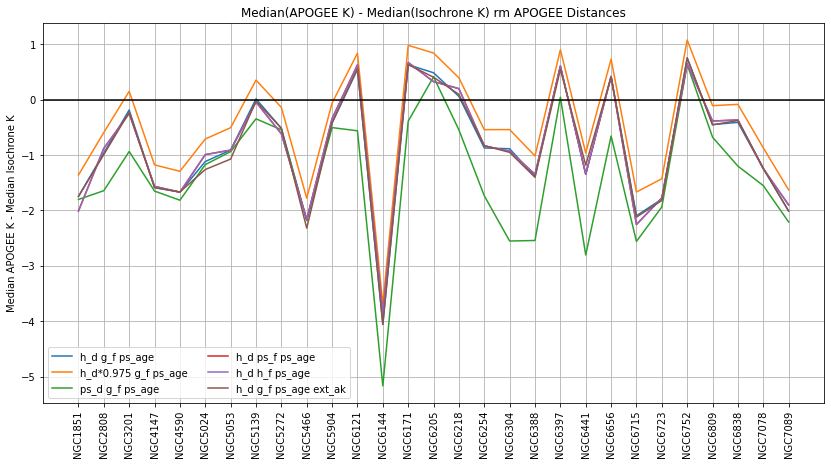

In [97]:
difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","d_d g_f ps_age",
            "a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,fifth_col,sixth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.plot(col_meds[i],label=difflabs[i])
plt.axhline(0,c='k')

plt.legend(ncol=2)

plt.xticks(np.arange(0.,29.,1.),supp2['Cluster'],rotation=90)
plt.grid()

plt.ylabel('Median APOGEE K - Median Isochrone K')
plt.title(r'Median(APOGEE K) - Median(Isochrone K)')
# plt.savefig('mediandiffK.pdf',bbox_inches='tight',dpi=300)
plt.show()

########################

difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","h_d h_f ps_age",
            "h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.plot(col_meds[i],label=difflabs[i])
plt.axhline(0,c='k')

plt.legend(ncol=2)

plt.xticks(np.arange(0.,29.,1.),supp2['Cluster'],rotation=90)
plt.grid()

plt.ylabel('Median APOGEE K - Median Isochrone K')
plt.title(r'Median(APOGEE K) - Median(Isochrone K) rm APOGEE Distances')
# plt.savefig('mediandiffK_rmapogee.pdf',bbox_inches='tight',dpi=300)
plt.show()

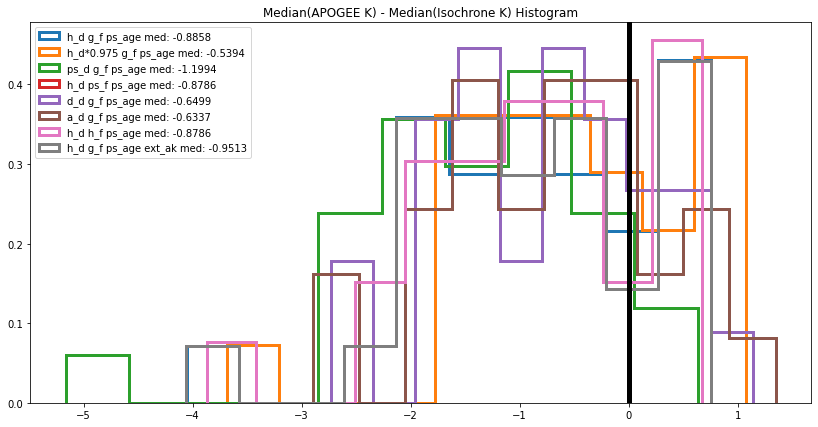

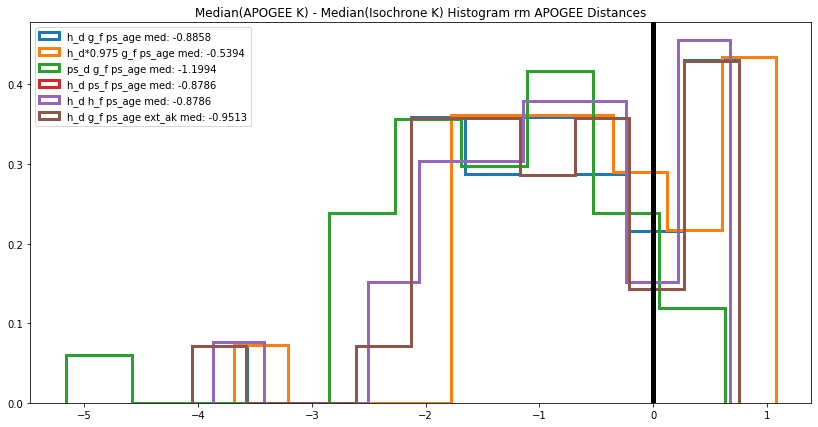

In [98]:
difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","d_d g_f ps_age",
            "a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,fifth_col,sixth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.hist(col_meds[i],label=difflabs[i]+' med: {:.4f}'.format(np.median(col_meds[i])),density=True,lw=3.0,
             histtype='step')
plt.axvline(0,c='k',lw=5.0)

plt.legend(loc='upper left')

plt.title(r'Median(APOGEE K) - Median(Isochrone K) Histogram')
# plt.savefig('mediandiffK_hist.pdf',bbox_inches='tight',dpi=300)
plt.show()

#######

difflabs = ["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","h_d h_f ps_age",
            "h_d g_f ps_age ext_ak"]
col_meds = [first_col,second_col,third_col,fourth_col,seventh_col,eighth_col]
plt.figure(figsize=[14,7])
for i in range(len(col_meds)):
    plt.hist(col_meds[i],label=difflabs[i]+' med: {:.4f}'.format(np.median(col_meds[i])),density=True,lw=3.0,
             histtype='step')
plt.axvline(0,c='k',lw=5.0)
plt.legend(loc='upper left')

plt.title(r'Median(APOGEE K) - Median(Isochrone K) Histogram rm APOGEE Distances')
# plt.savefig('mediandiffK_hist_rmapogee.pdf',bbox_inches='tight',dpi=300)
plt.show()

In [24]:
# z = np.polyfit(gcs['AK_TARG'], gcs['Ejk_med'], 1)
# p = np.poly1d(z)

# plt.figure(figsize=[10,10])
# plt.scatter(gcs['AK_TARG'],gcs['Ejk_med'],label='APOGEE Stars')
# plt.plot([0,1],[0,1],c='k',ls='--',lw=3.0,label='1-to-1')
# plt.plot([0,1],[0,1.5],c='r',lw=3.0,label=r'E(J - K) = 1.5A$_K$')
# # plt.plot([-0.5,1],[p(-0.5),p(1)],lw=3.0,c='darkorange',label='Polyfit')

# plt.legend()

# plt.ylim(0,1.2)

# plt.xlabel(r'AK_TARG')
# plt.ylabel(r'Ejk_med')

# plt.title(r'Compare Ejk_med and AK_TARG')
# plt.savefig('ak_ext_compare.pdf',bbox_inches='tight',dpi=300)
# plt.show()

# median offsets

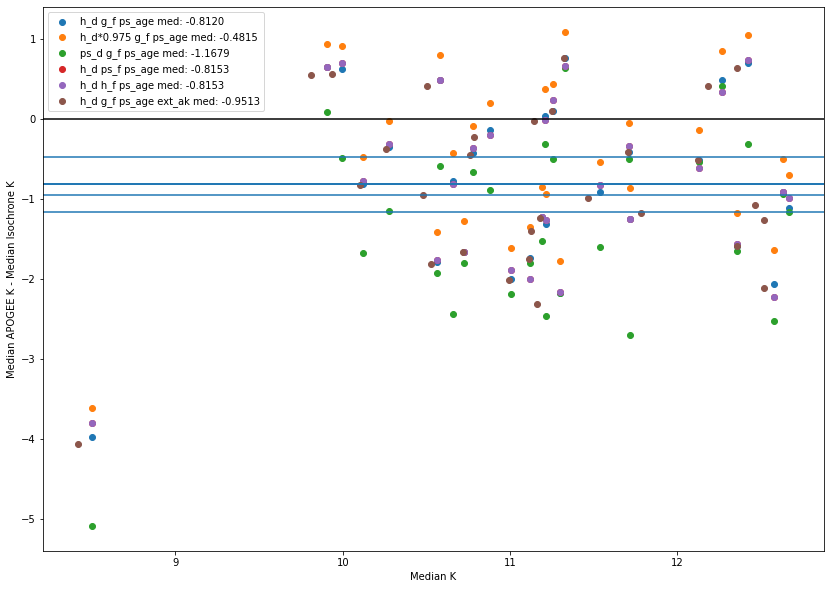

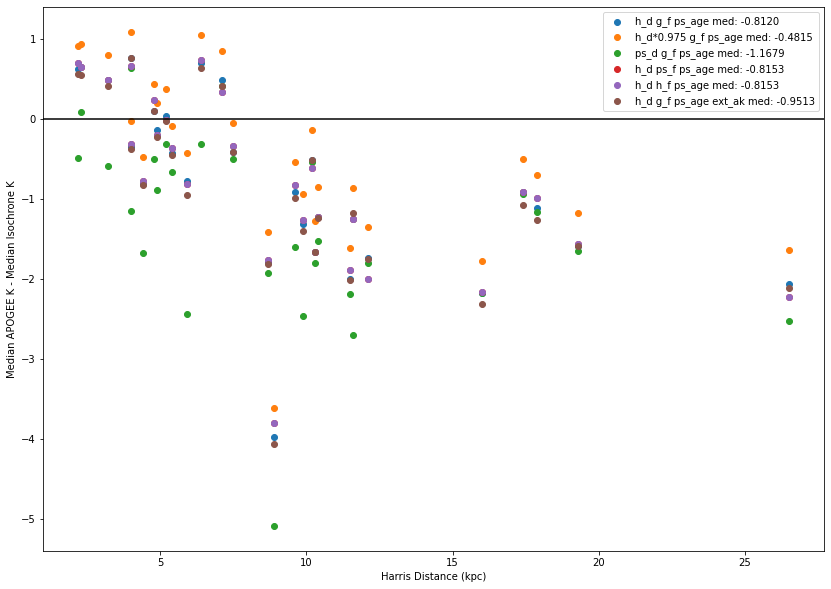

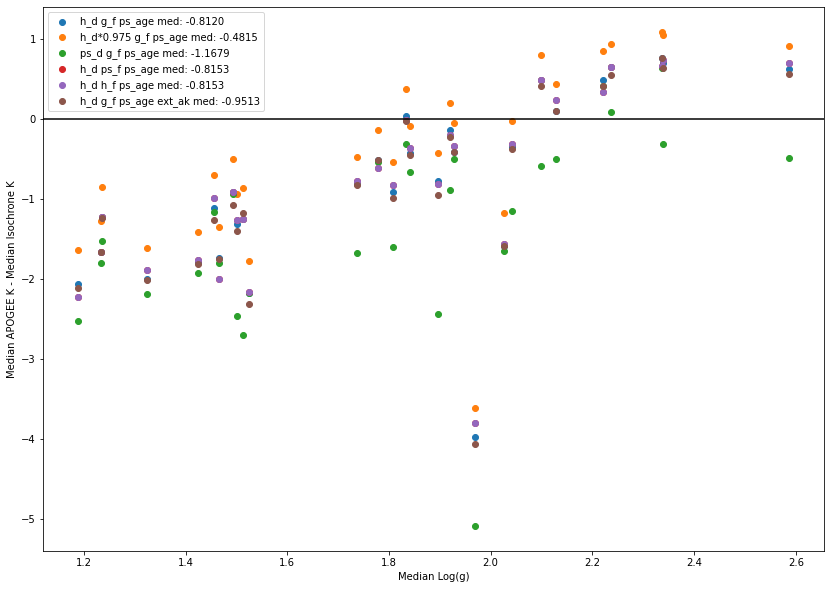

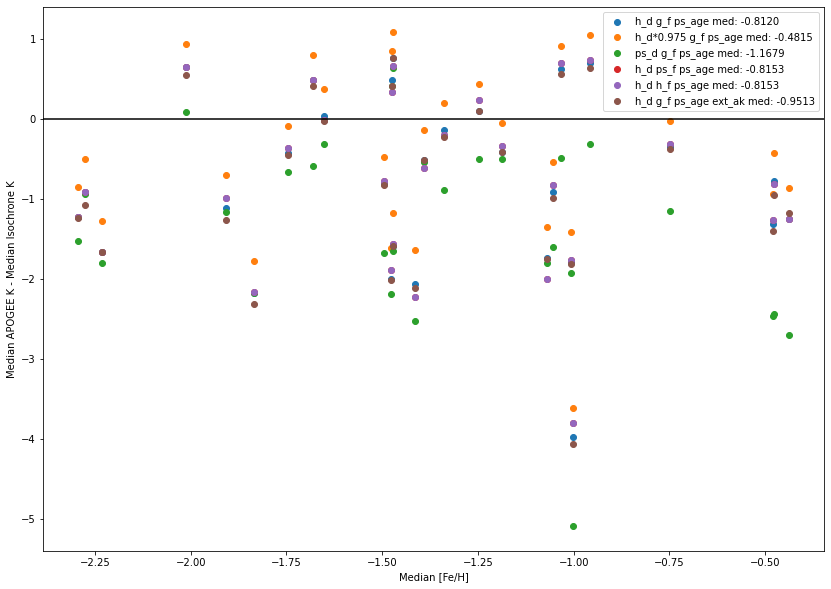

In [25]:
lab_cols = np.array(["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age","d_d g_f ps_age",
            "a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"])
offset_cols = np.array([first_col,second_col,third_col,fourth_col,fifth_col,sixth_col,seventh_col,eighth_col])
meds_cols = np.array([first_med_gcs,second_med_gcs,third_med_gcs,fourth_med_gcs,fifth_med_gcs,sixth_med_gcs,
                      seventh_med_gcs,eighth_med_gcs])

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    plt.scatter(meds_cols[i],offset_cols[i],label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.axhline(np.median(offset_cols[i]))
    
plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

#########

plt.figure(figsize=[14,10])
for i in range(len(offset_cols)):
    if i not in [4,5]:
        plt.scatter(supp2['harris_dist'],offset_cols[i],
                    label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
        
#     plt.axhline(np.median(offset_cols[i]))

plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Harris Distance (kpc)')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()


#########

plt.figure(figsize=[14,10])
for i in range(len(offset_cols)):
    if i not in [4,5]:
        plt.scatter(med_g,offset_cols[i],
                    label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
        
#     plt.axhline(np.median(offset_cols[i]))

plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Median Log(g)')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

############

plt.figure(figsize=[14,10])
for i in range(len(offset_cols)):
    if i not in [4,5]:
        plt.scatter(med_f,offset_cols[i],
                    label=lab_cols[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
        
#     plt.axhline(np.median(offset_cols[i]))

plt.axhline(0,c='k')

plt.legend()    

plt.xlabel(r'Median [Fe/H]')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()


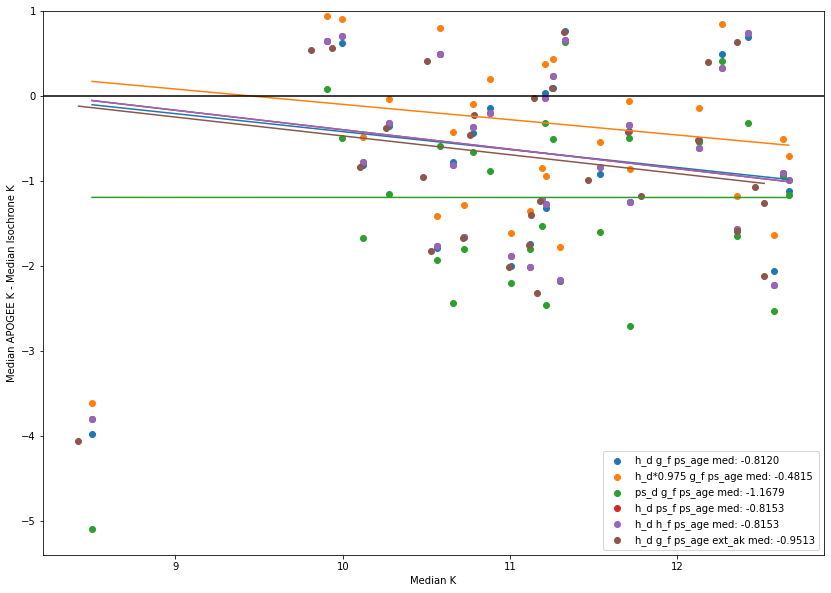

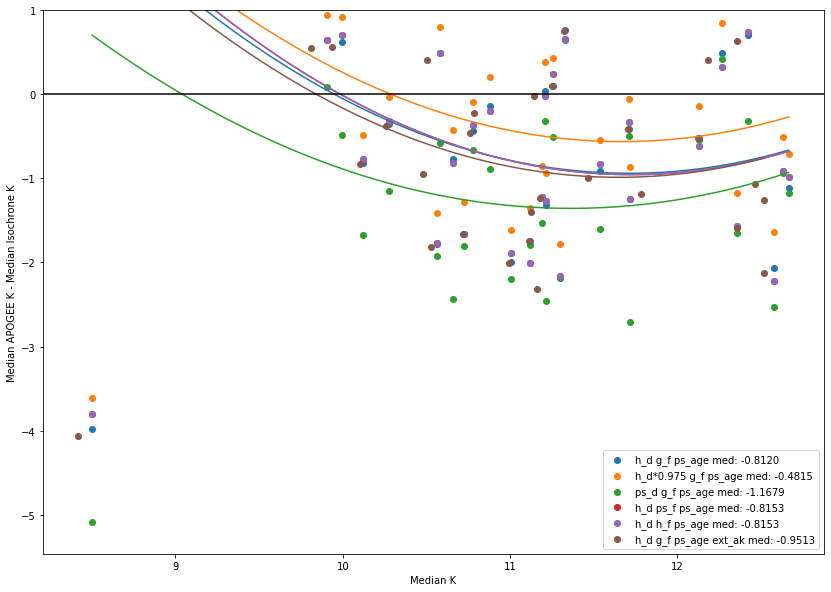

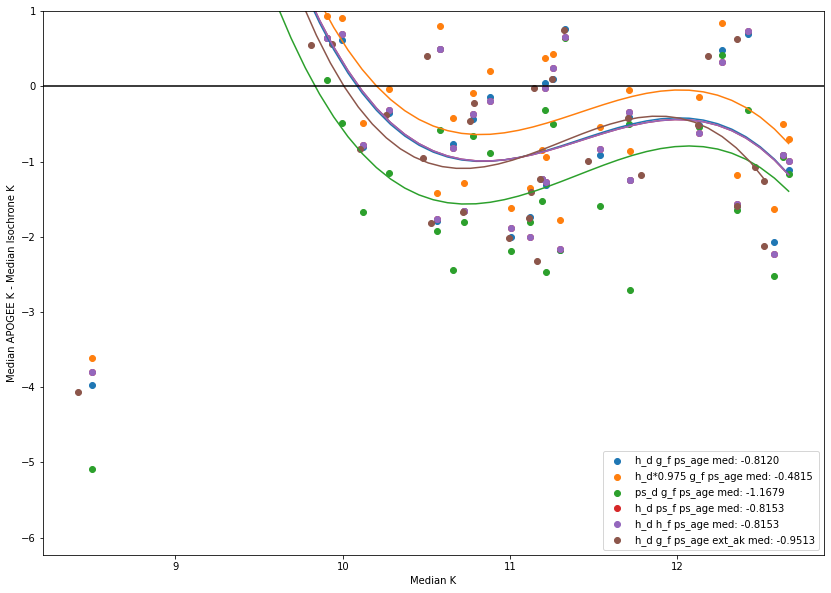

In [26]:
goo_clus = np.where(supp2['Cluster']!='NGC6144')

linParams = []
quaParams = []
cubParams = []

for i in [0,1,2,3,4,5,6,7]:
    linParams.append(np.polyfit(np.asarray(meds_cols[i])[goo_clus],np.asarray(offset_cols[i])[goo_clus],1))
    quaParams.append(np.polyfit(np.asarray(meds_cols[i])[goo_clus],np.asarray(offset_cols[i])[goo_clus],2))
    cubParams.append(np.polyfit(np.asarray(meds_cols[i])[goo_clus],np.asarray(offset_cols[i])[goo_clus],3))

poly_labels = np.array(["h_d g_f ps_age","h_d*0.975 g_f ps_age","ps_d g_f ps_age","h_d ps_f ps_age",
                        "d_d g_f ps_age","a_d g_f ps_age","h_d h_f ps_age","h_d g_f ps_age ext_ak"])

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    x = np.linspace(min(meds_cols[i]),max(meds_cols[i]))
    
    plt.scatter(meds_cols[i],offset_cols[i],label=poly_labels[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.plot(x,np.poly1d(linParams[i])(x))
plt.axhline(0,c='k')

plt.ylim(top=1.)

plt.legend()

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

###

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    x = np.linspace(min(meds_cols[i]),max(meds_cols[i]))
    
    plt.scatter(meds_cols[i],offset_cols[i],label=poly_labels[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.plot(x,np.poly1d(quaParams[i])(x))
plt.axhline(0,c='k')

plt.ylim(top=1.)

plt.legend()

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

###

plt.figure(figsize=[14,10])
for i in np.delete(range(8),[4,5]):
    x = np.linspace(min(meds_cols[i]),max(meds_cols[i]))
    
    plt.scatter(meds_cols[i],offset_cols[i],label=poly_labels[i]+' med: {:.4f}'.format(np.median(offset_cols[i])))
    plt.plot(x,np.poly1d(cubParams[i])(x))
plt.axhline(0,c='k')

plt.ylim(top=1.)

plt.legend()

plt.xlabel(r'Median K')
plt.ylabel(r'Median APOGEE K - Median Isochrone K')
plt.show()

# Explore Harris Distance Scaling

In [27]:
dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.
fact = np.arange(0.85,1.0,0.01)
    
all_diff_shifts = []
all_diff_shifts_med = [] 
for i in range(len(fact)):
    clus_med_k = []
    for j in range(len(supp2)):
        meds = np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-np.median(lits_isos[j]['Ksmag']+dismod1[j]*fact[i])
        clus_med_k.append(meds)
    all_diff_shifts.append(clus_med_k)
    all_diff_shifts_med.append(np.median(clus_med_k))

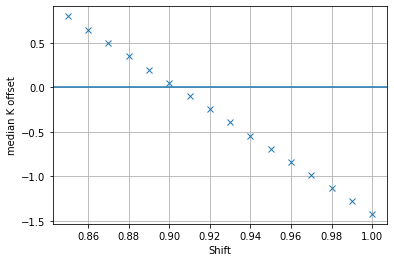

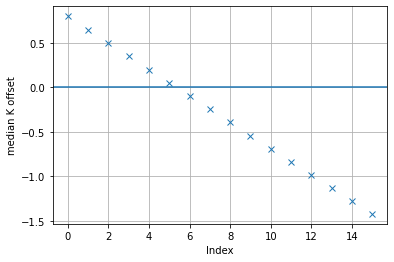

In [28]:
plt.plot(fact,all_diff_shifts_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Shift')
plt.show()

plt.plot(all_diff_shifts_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Index')
plt.show()


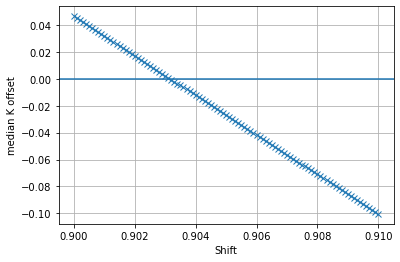

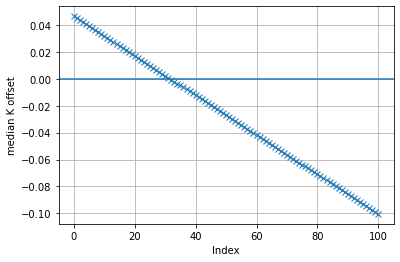

In [29]:
dismod1 = 5.*np.log10(supp2['harris_dist']*1000)-5.
fact_fin = np.arange(0.90,0.91,0.0001)
    
all_diff_shifts_fin = []
all_diff_shifts_fin_med = [] 
for i in range(len(fact_fin)):
    clus_med_k = []
    for j in range(len(supp2)):
        meds = (np.median((gcs['K']-gcs['Ejk_med']/1.5)[clus])-
                np.median(lits_isos[j]['Ksmag']+dismod1[j]*fact_fin[i]))
        clus_med_k.append(meds)
    all_diff_shifts_fin.append(clus_med_k)
    all_diff_shifts_fin_med.append(np.median(clus_med_k))
    
plt.plot(fact_fin,all_diff_shifts_fin_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Shift')
plt.show()

plt.plot(all_diff_shifts_fin_med,marker='x',ls='none')
plt.axhline(0)
plt.grid()
plt.ylabel(r'median K offset')
plt.xlabel(r'Index')
plt.show()

In [30]:
# Scale Closest to zero offset in median K
fact_fin[np.where(all_diff_shifts_fin_med==-min(np.abs(all_diff_shifts_fin_med)))]

array([0.9032])

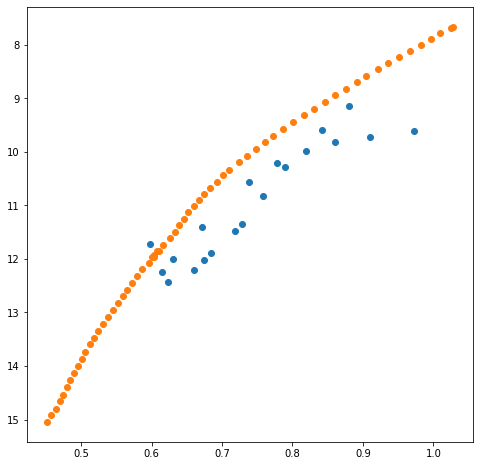

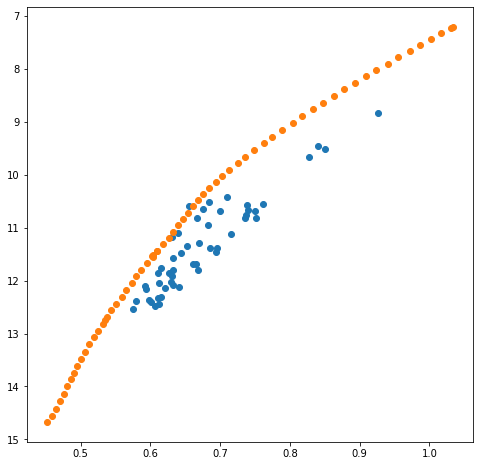

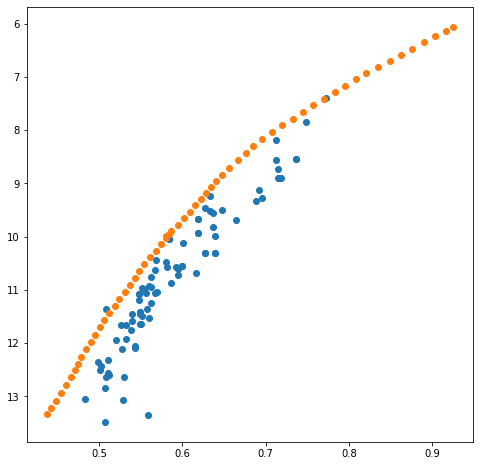

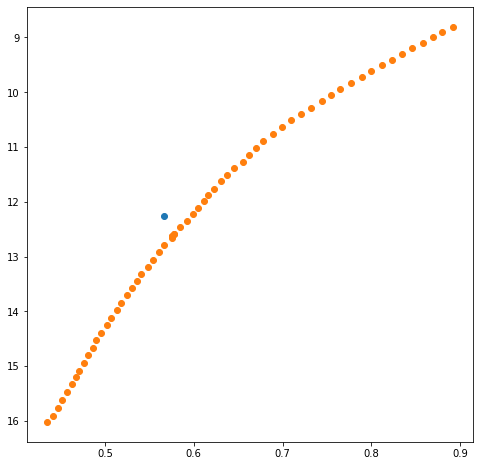

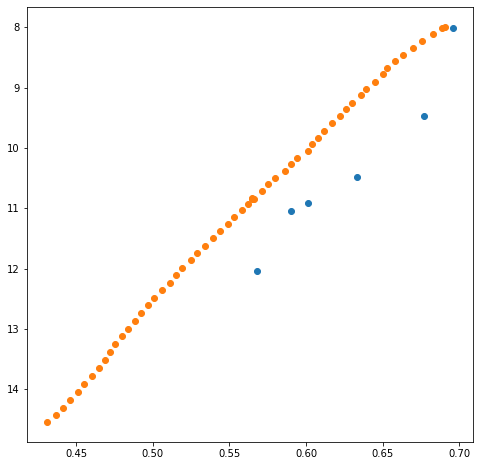

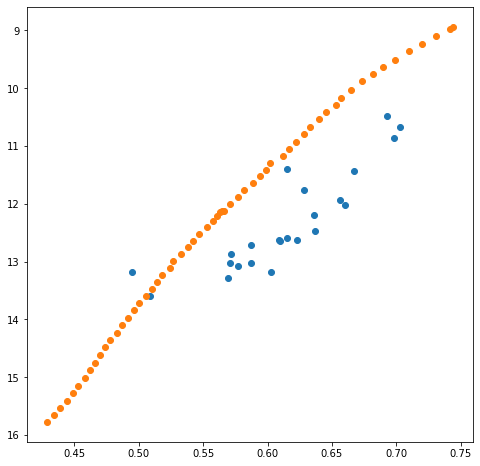

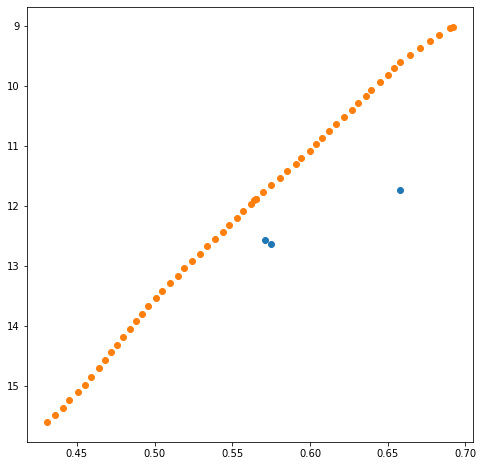

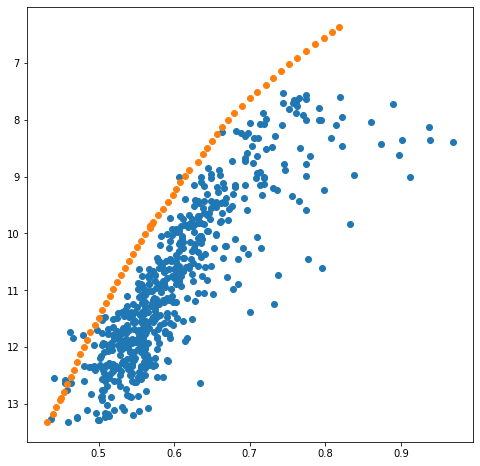

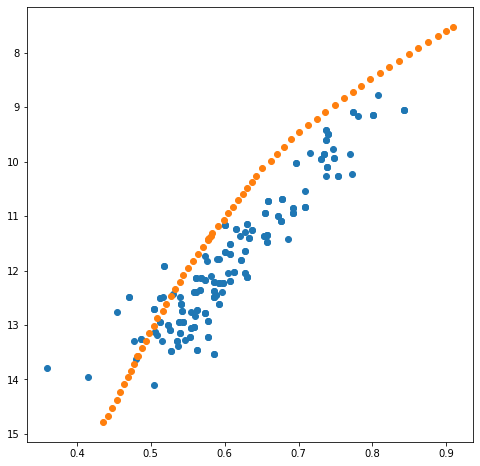

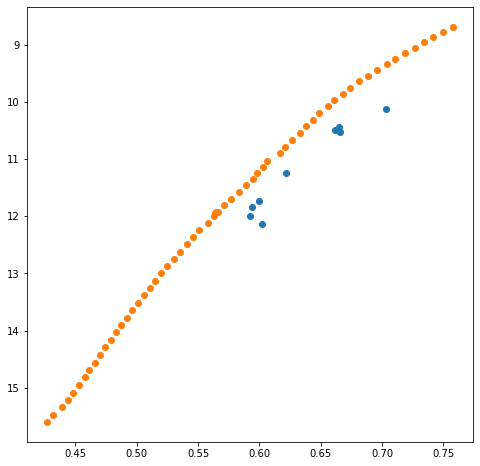

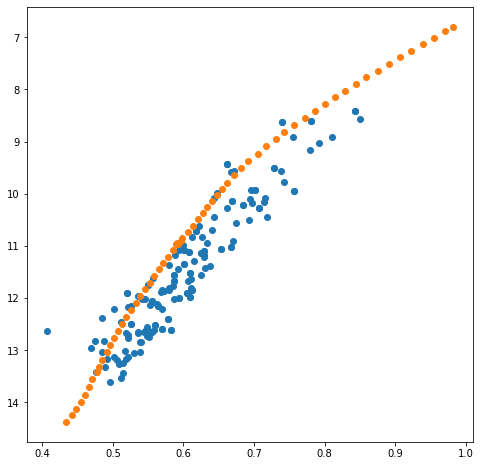

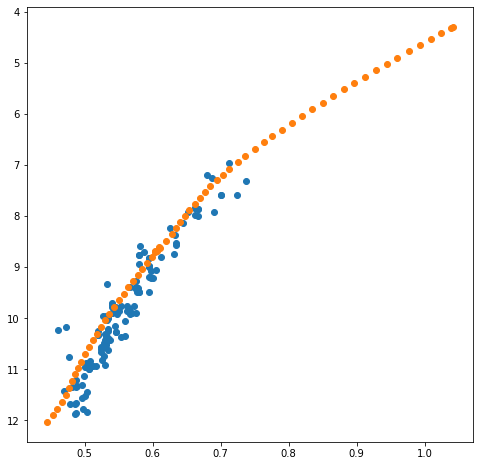

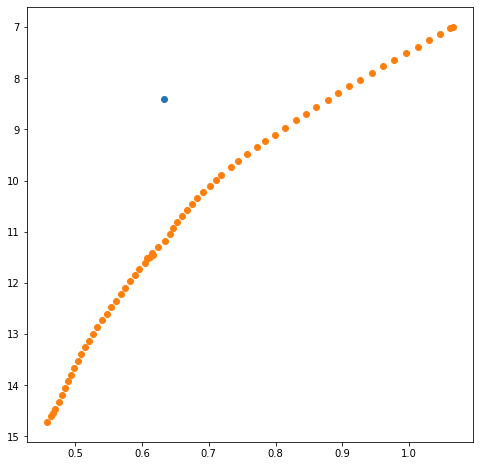

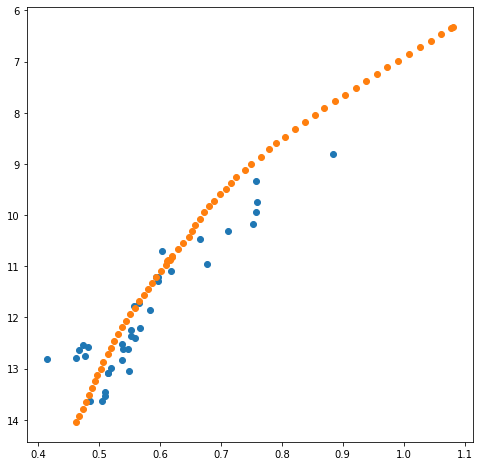

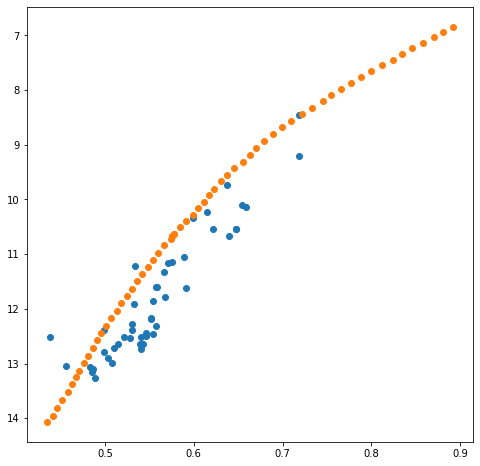

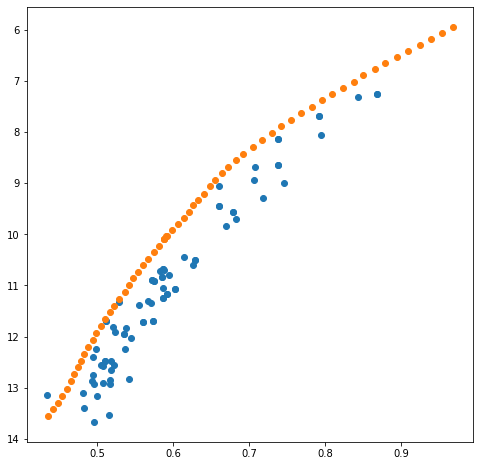

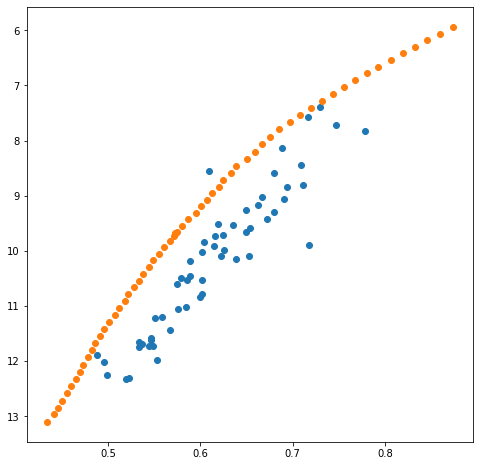

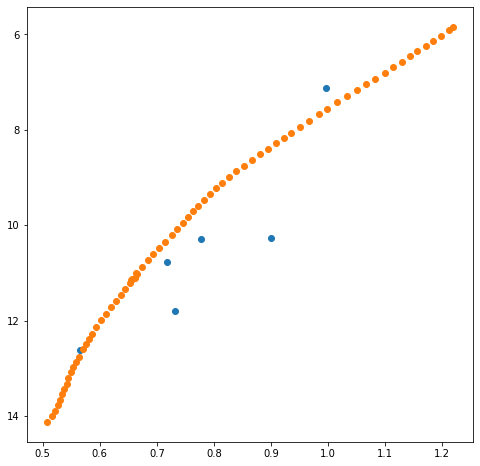

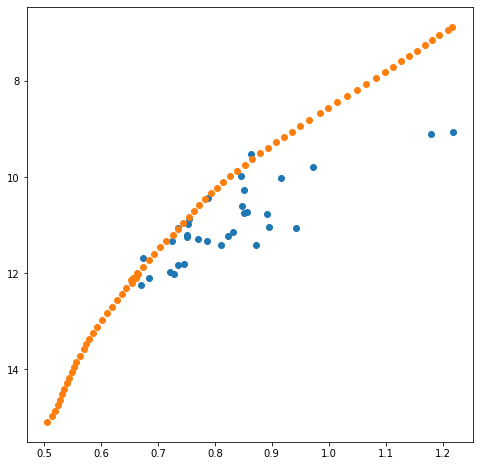

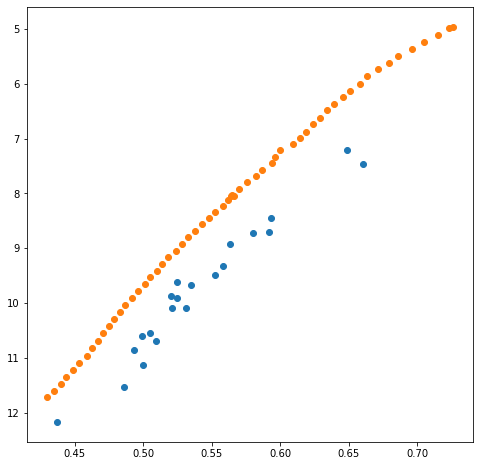

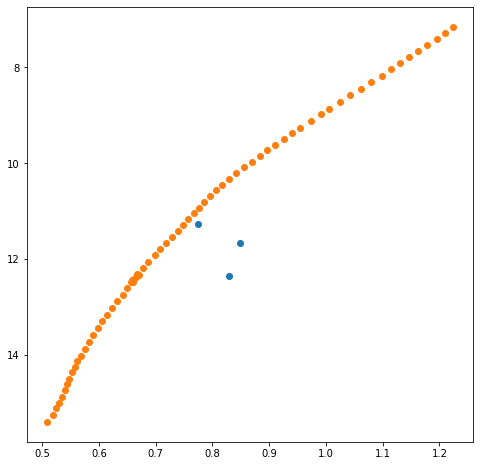

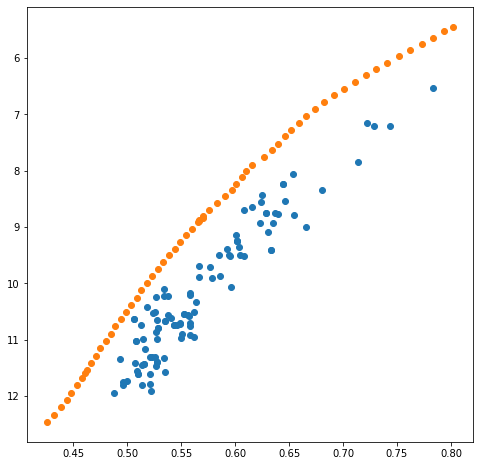

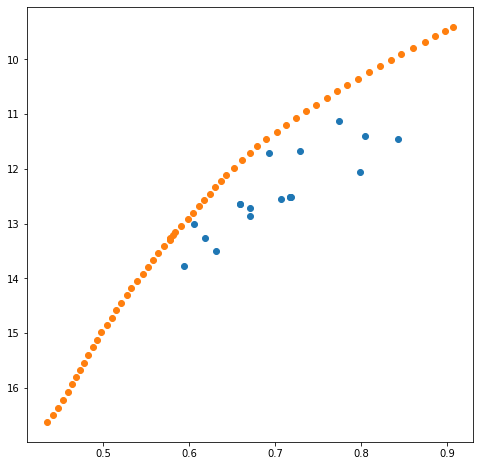

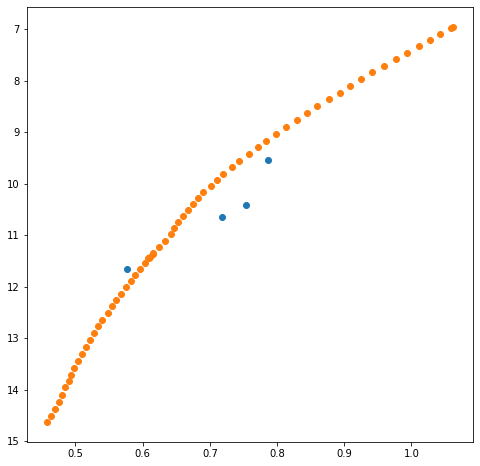

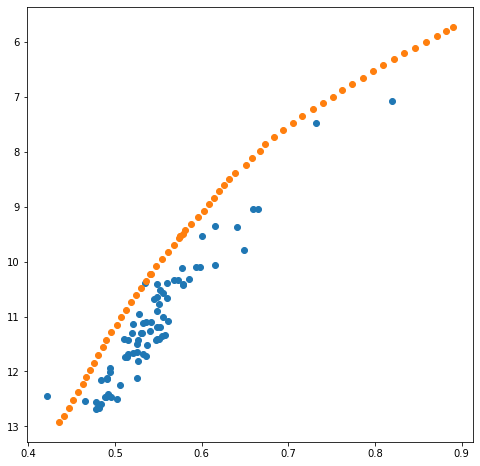

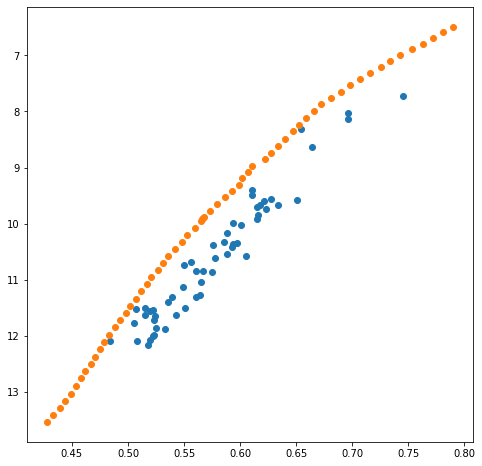

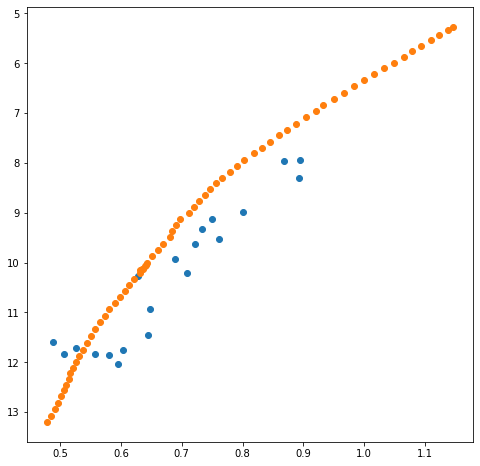

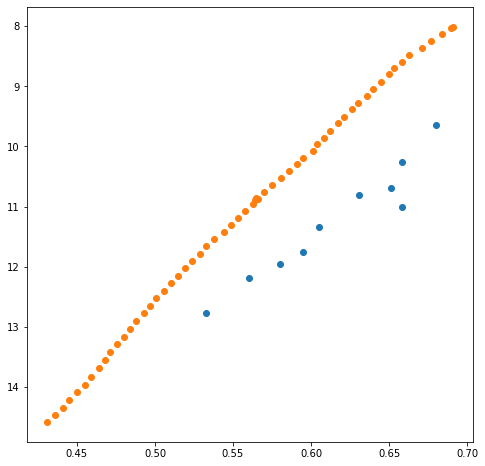

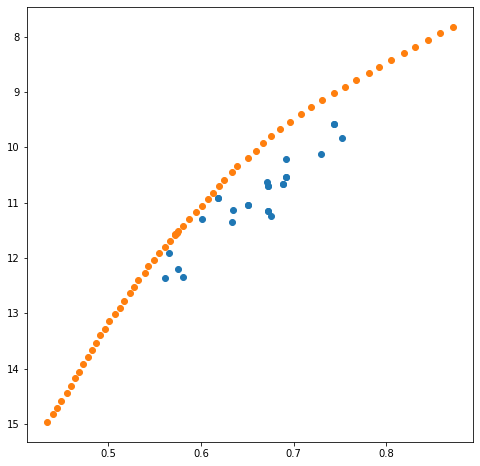

In [31]:
for i in range(len(supp2)):
    plt.figure(figsize=[8,8])
    clus = np.where(ngc_names==supp2['Cluster'][i])

    plt.scatter((gcs['J']-gcs['K']-gcs['Ejk_med'])[clus],(gcs['K']-gcs['Ejk_med']/1.5)[clus])
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]*0.9032)
    
    plt.gca().invert_yaxis()
    
    plt.show()

In [32]:
10**9.5/10**9

3.1622776601683795

<font size='15'>
    <b>
        Reddening And Extinction From Scratch
    </b>
</font>

In [36]:
# supp2

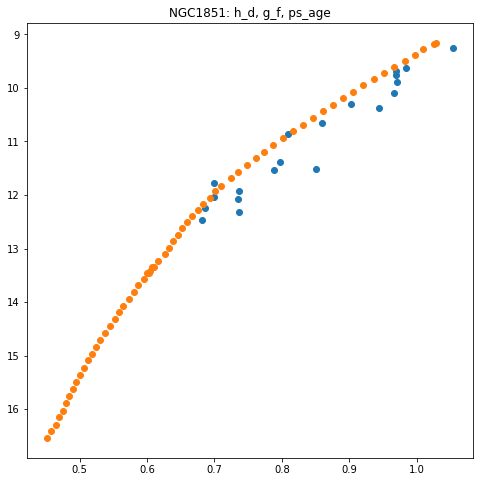

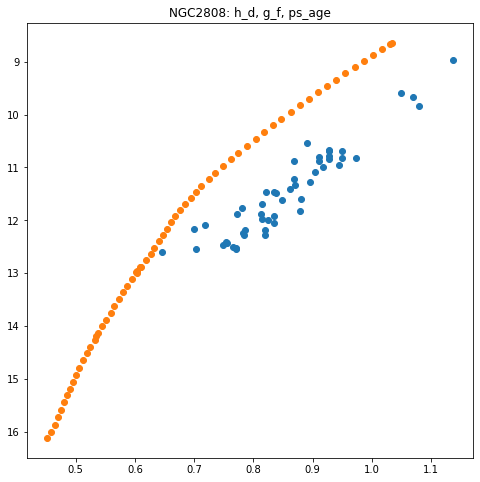

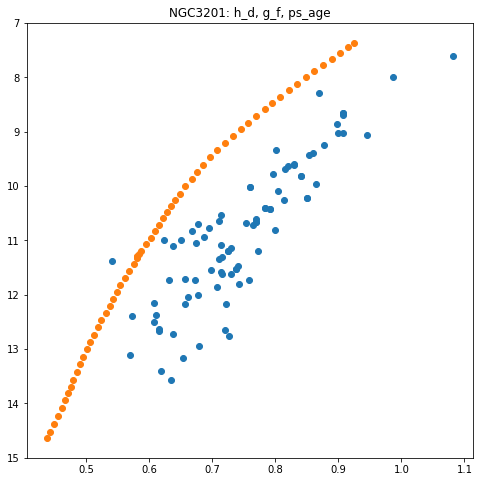

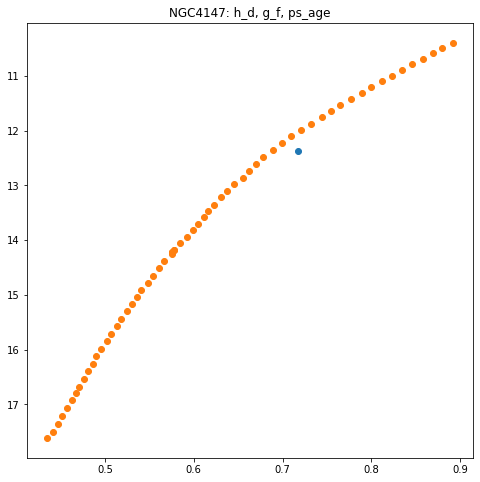

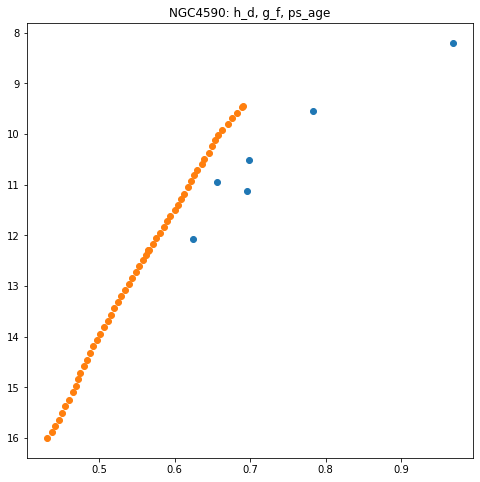

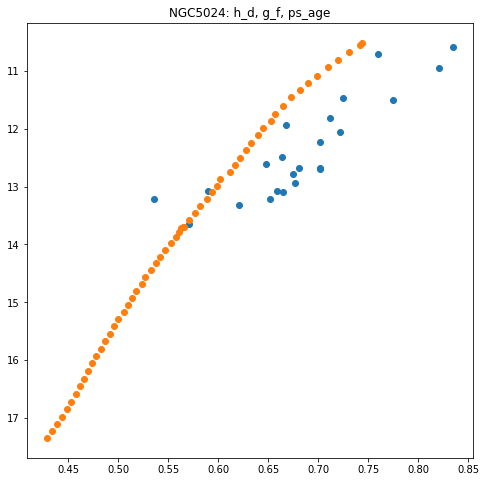

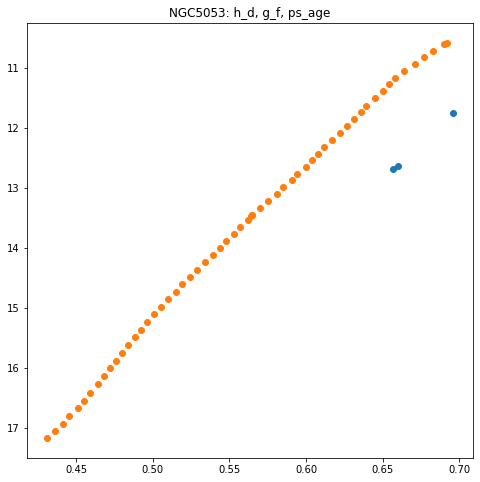

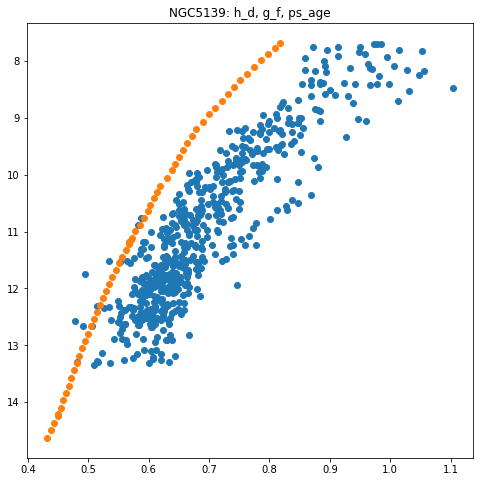

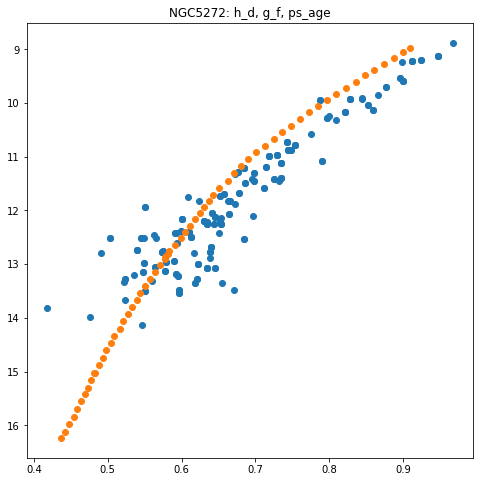

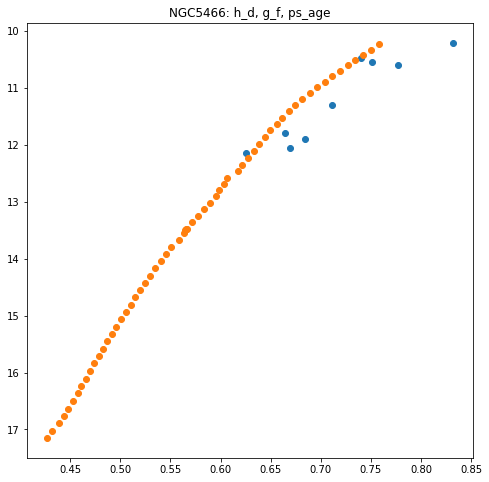

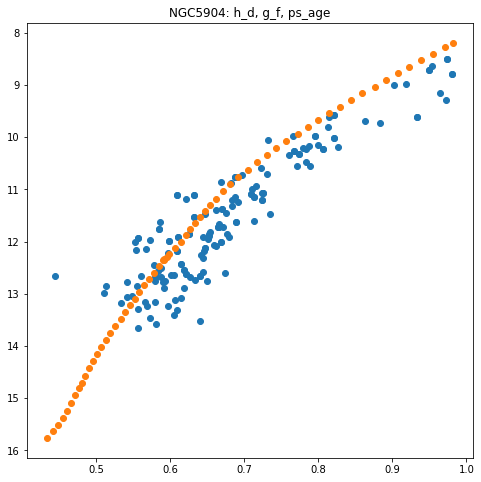

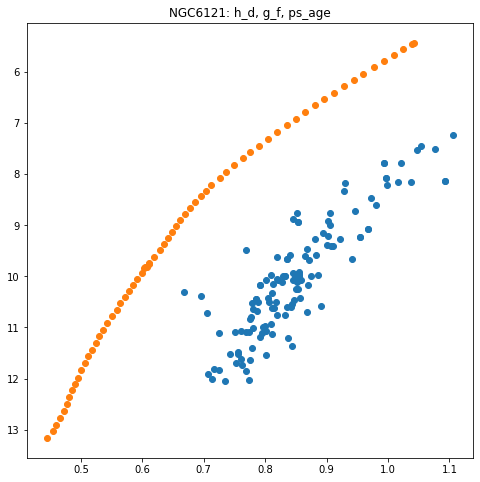

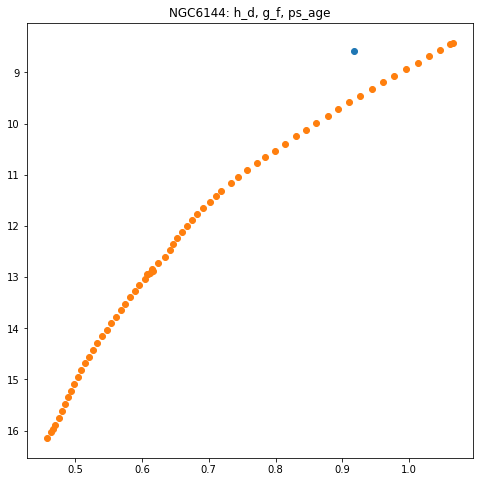

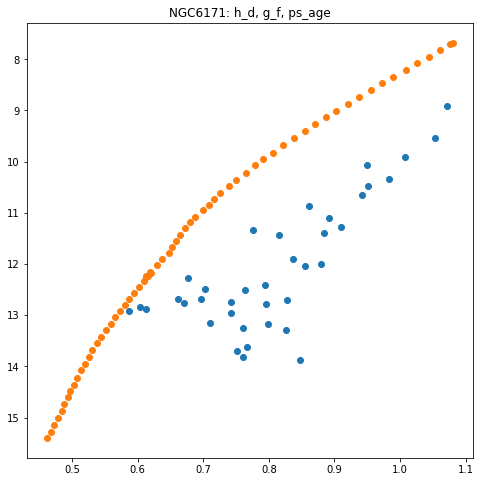

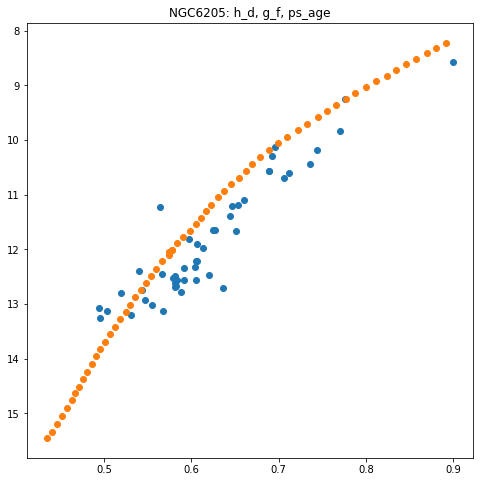

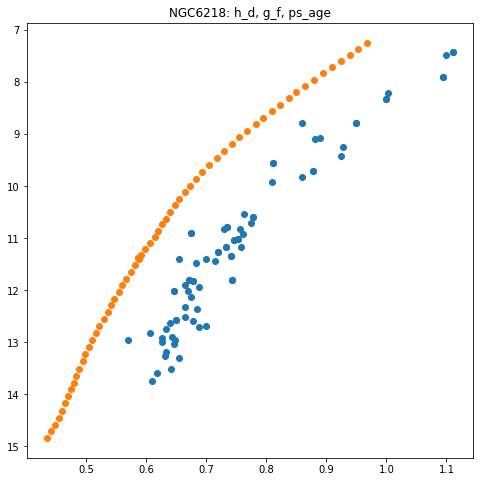

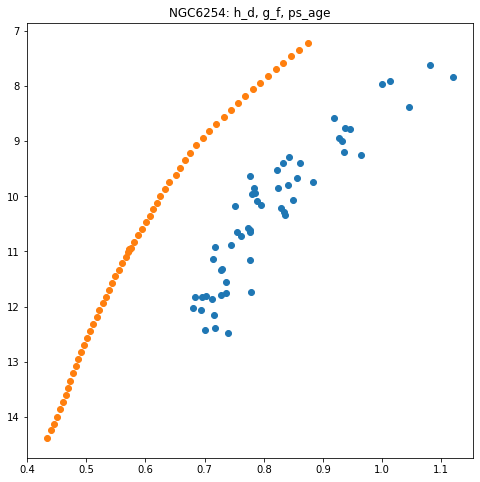

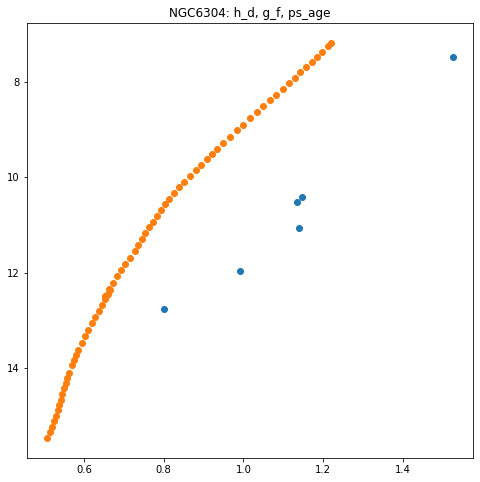

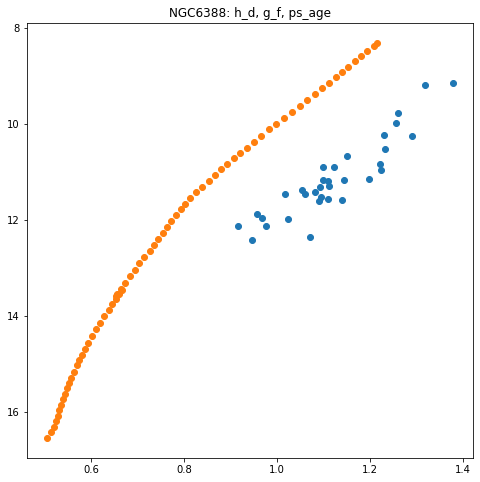

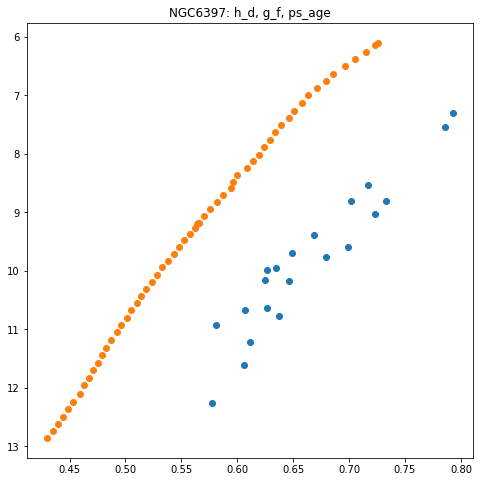

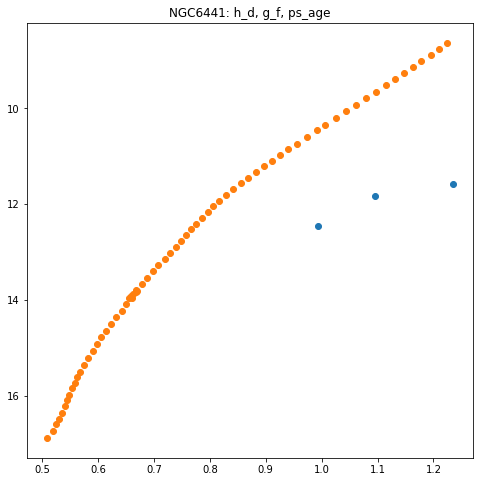

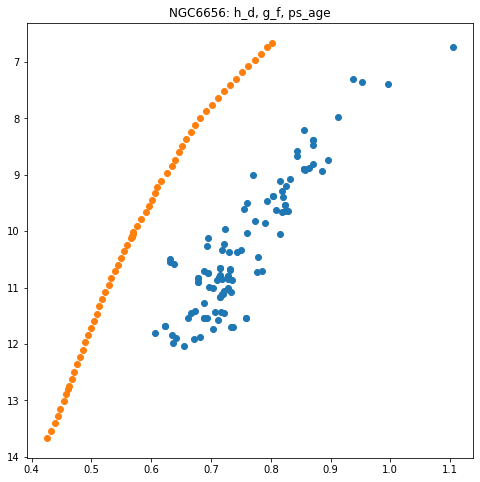

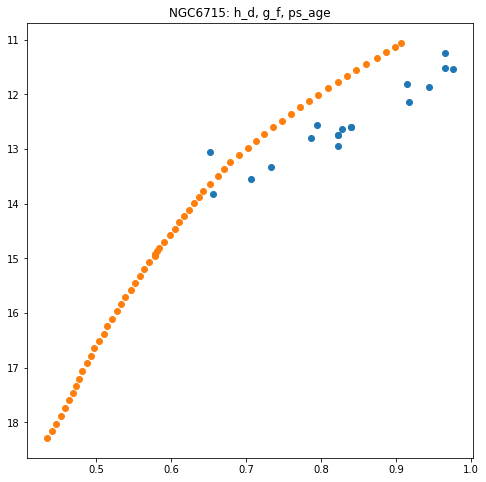

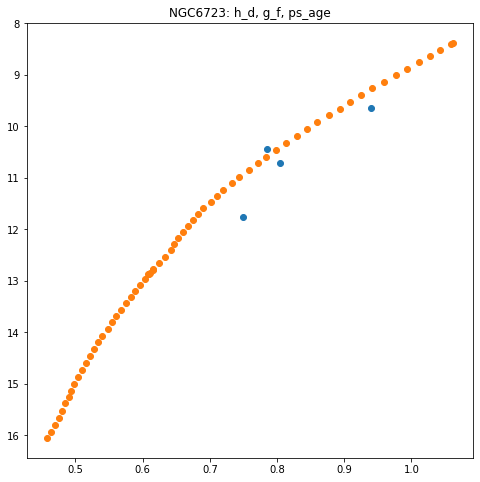

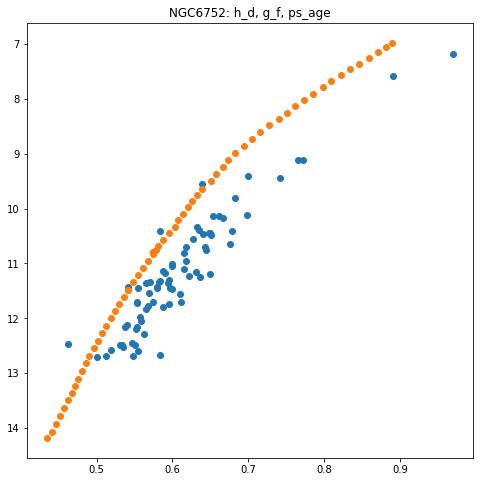

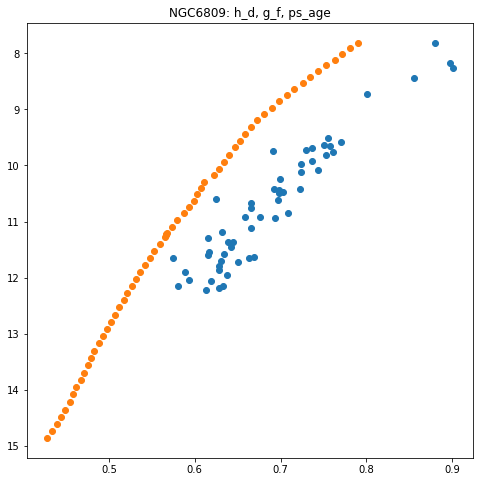

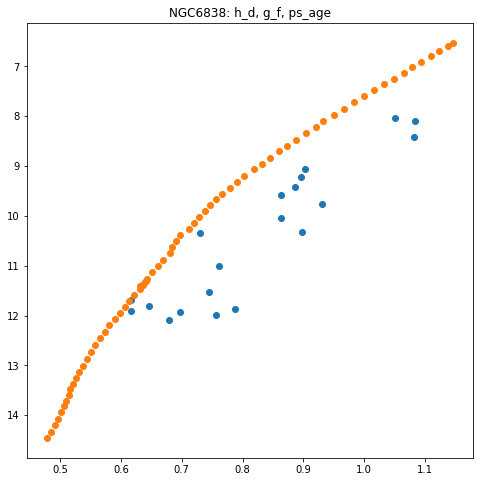

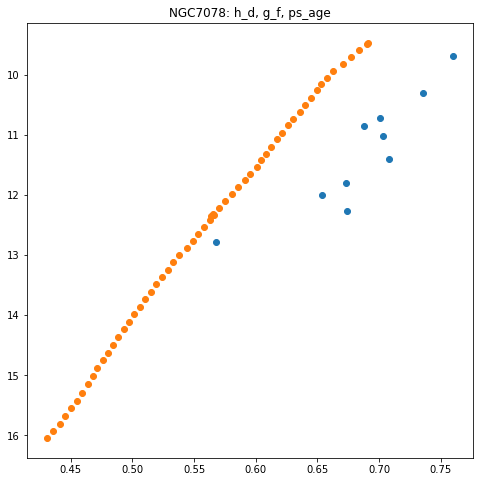

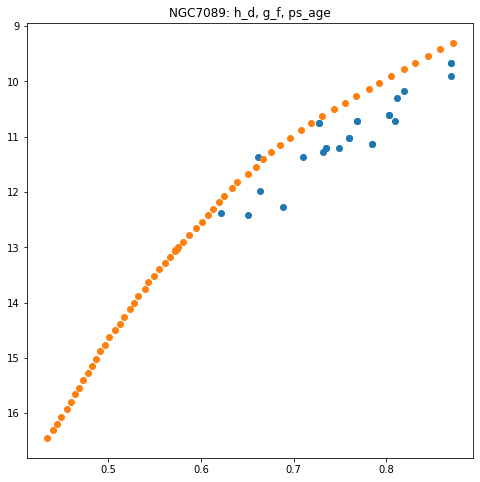

In [48]:
lit_iso_med_k = []
lit_iso_med_jk = []

apo_med_k = []
apo_med_jk = []

for i in range(len(supp2)):
    plt.figure(figsize=[8,8])
    clus = np.where(ngc_names==supp2['Cluster'][i])

    plt.scatter((gcs['J']-gcs['K'])[clus],gcs['K'][clus])
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: h_d, g_f, ps_age'.format(supp2['Cluster'][i]))
    
    plt.show()
    
    lit_iso_med_k.append(np.median(lits_isos[i]['Ksmag']+dismod1[i]))
    lit_iso_med_jk.append(np.median(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag']))
    
    apo_med_k.append(np.median(gcs['K'][clus]))
    apo_med_jk.append(np.median((gcs['J']-gcs['K'])[clus]))

In [56]:
test_ak = np.asarray(lit_iso_med_k)-np.asarray(apo_med_k)
np.median(np.asarray(lit_iso_med_k)-np.asarray(apo_med_k))

0.7437631230315223

In [57]:
test_ejk = (np.asarray(lit_iso_med_jk)-np.asarray(apo_med_jk))
np.median((np.asarray(lit_iso_med_jk)-np.asarray(apo_med_jk)))

-0.14199973678588895

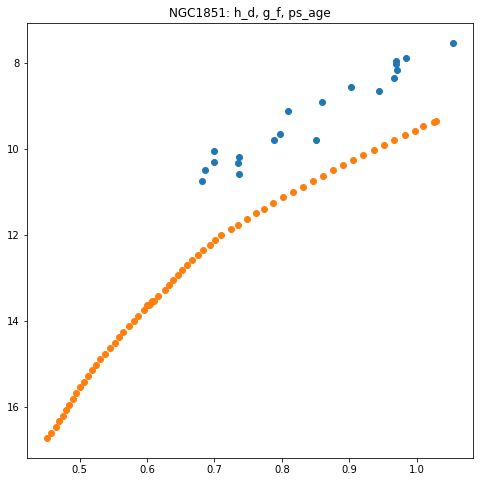

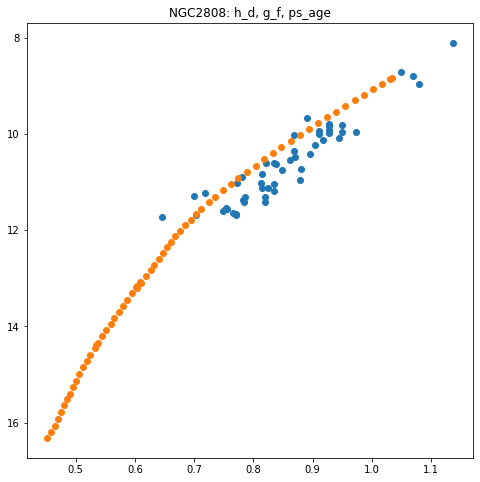

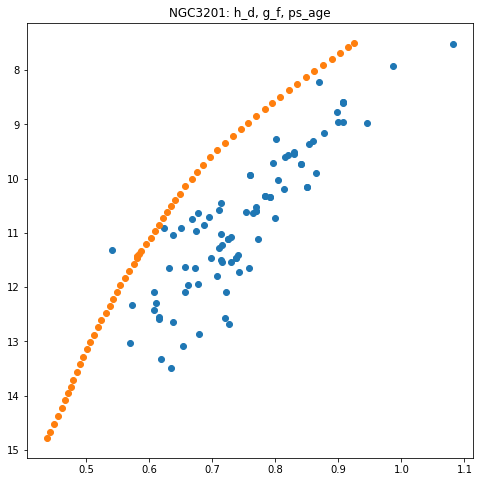

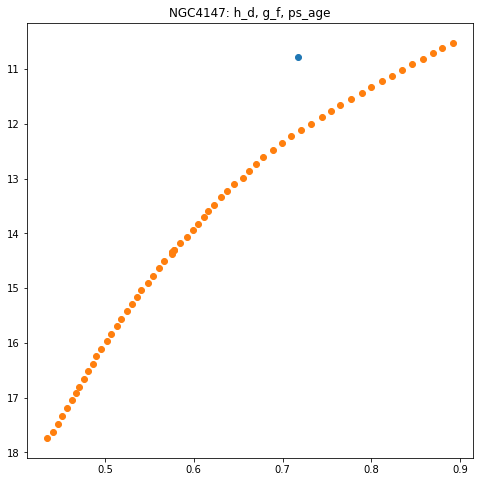

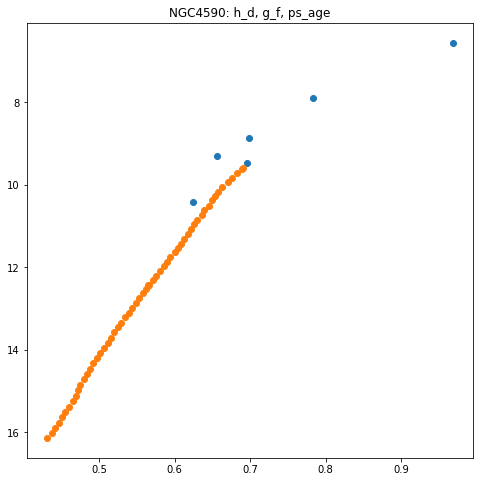

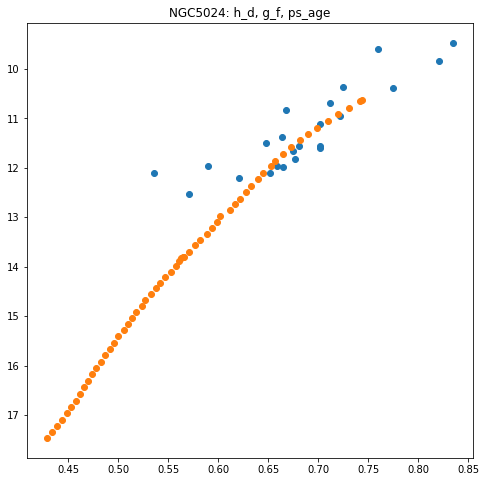

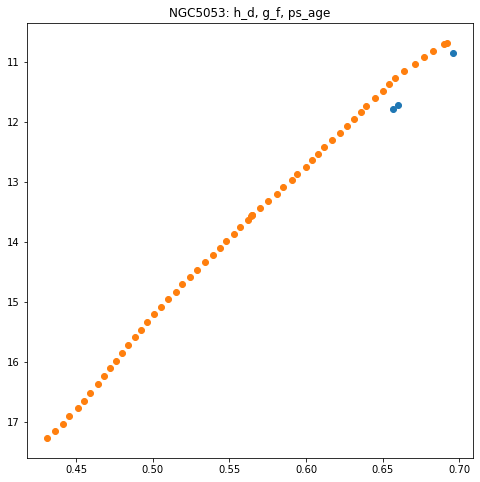

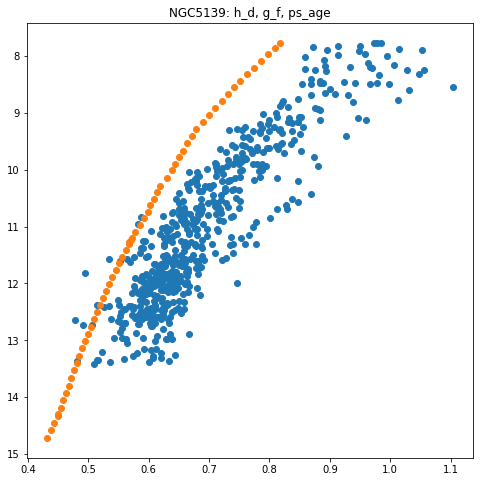

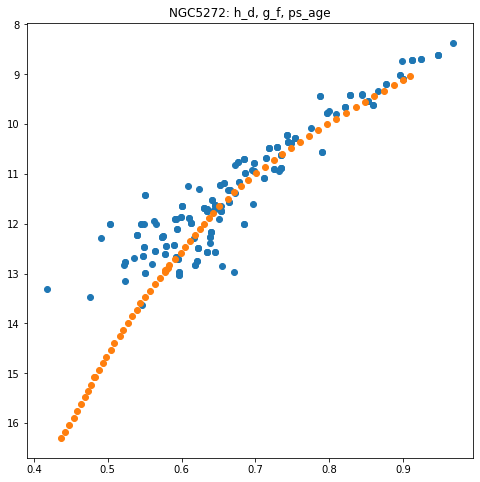

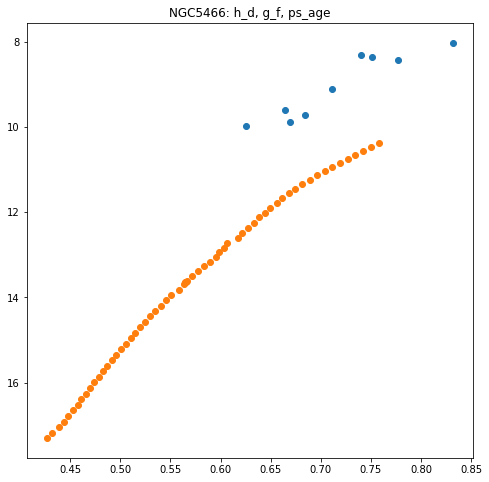

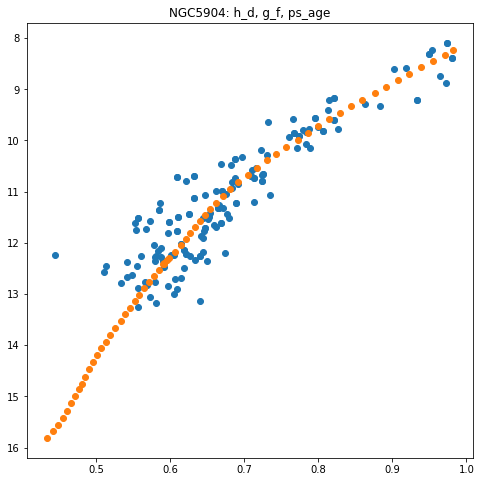

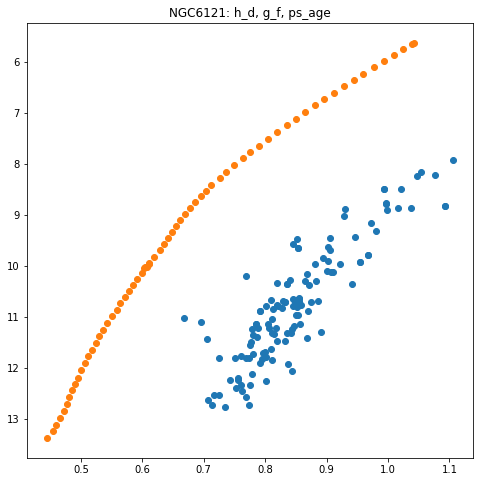

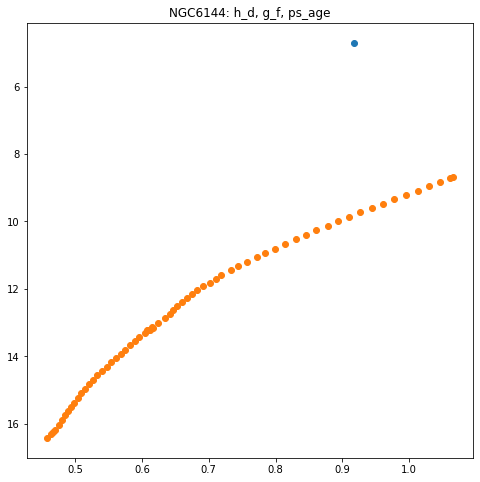

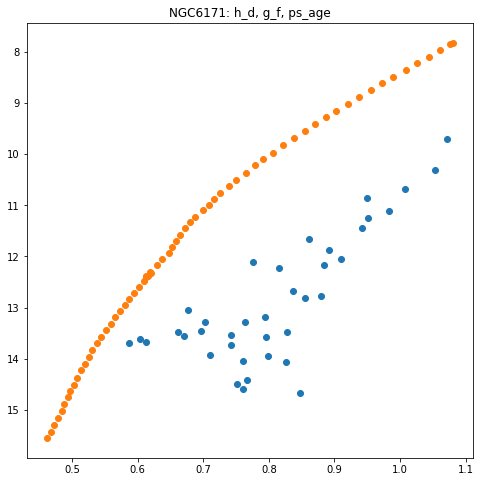

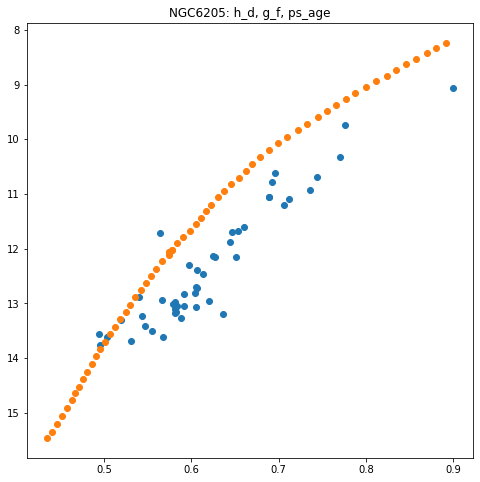

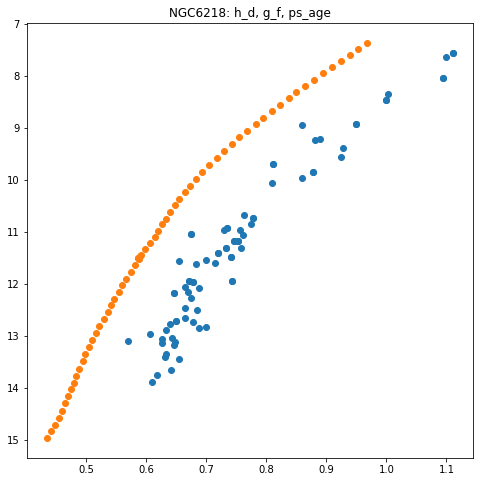

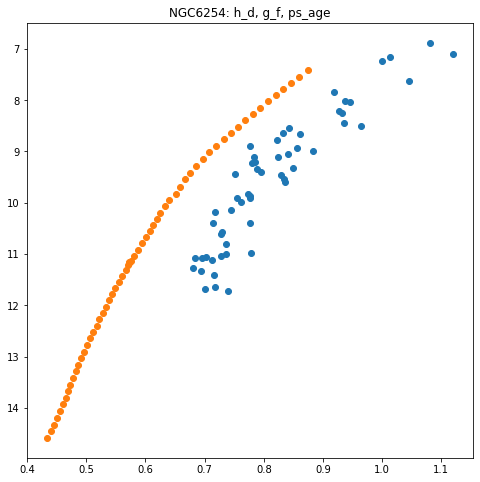

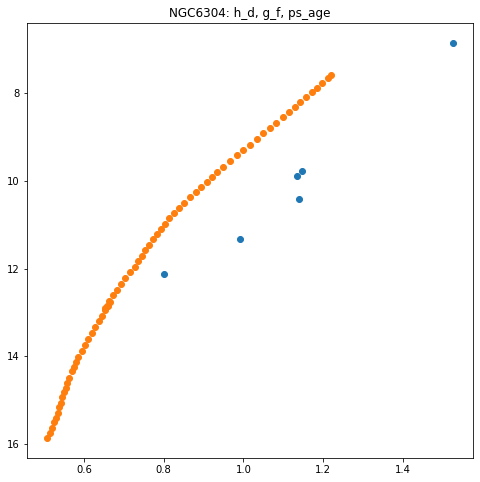

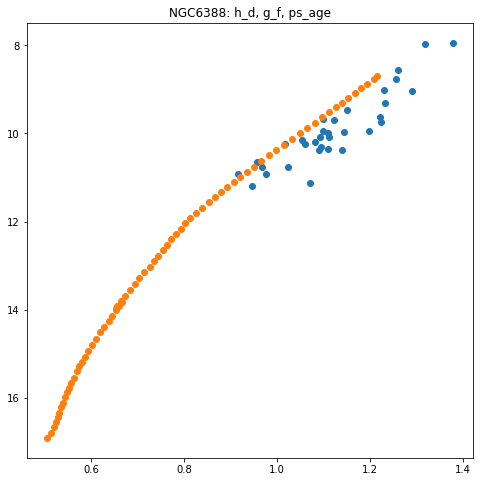

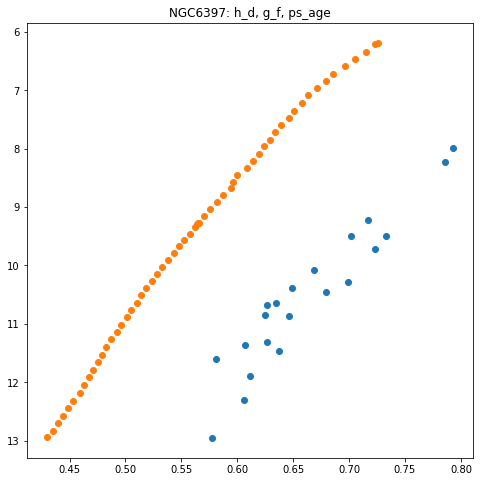

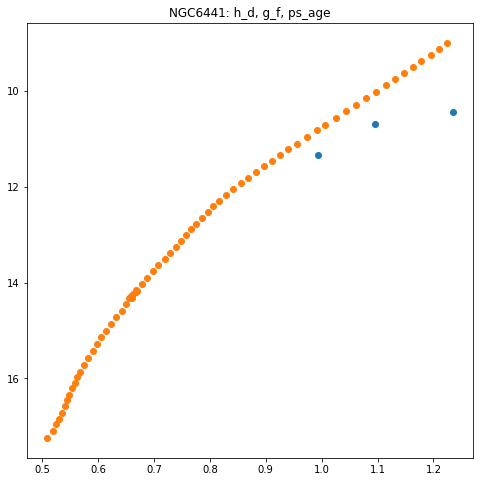

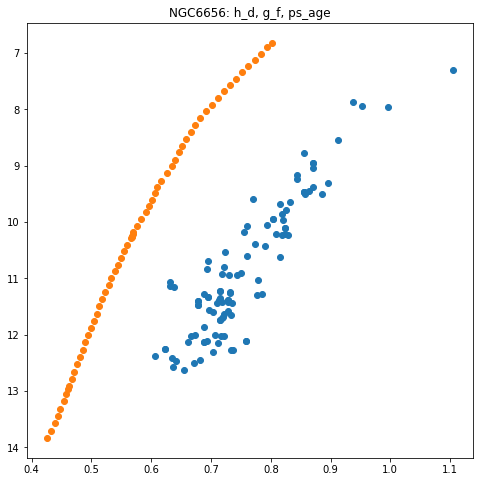

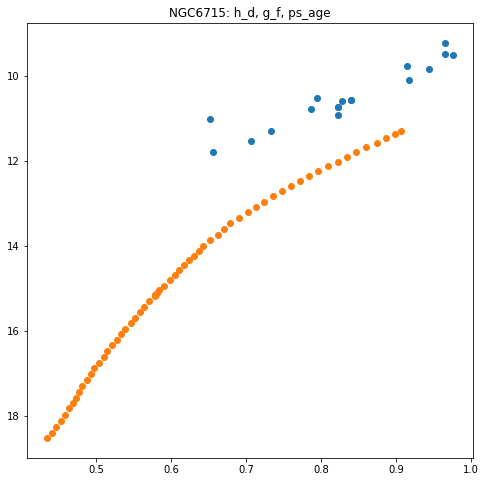

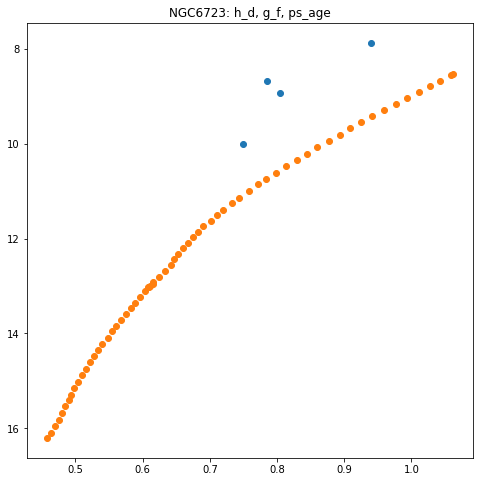

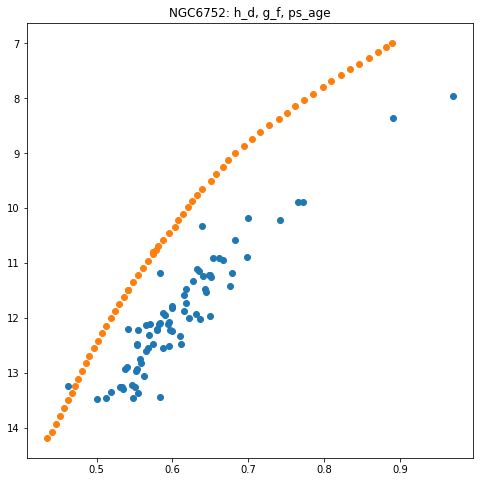

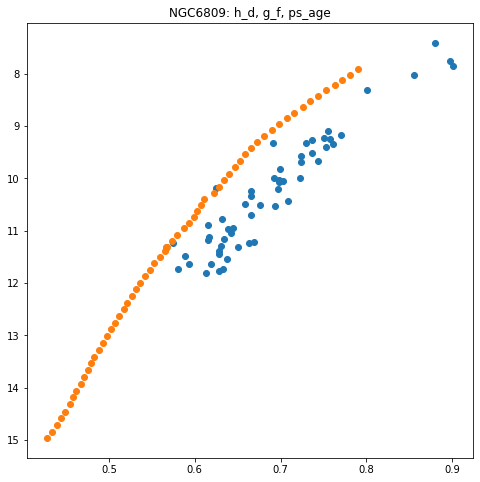

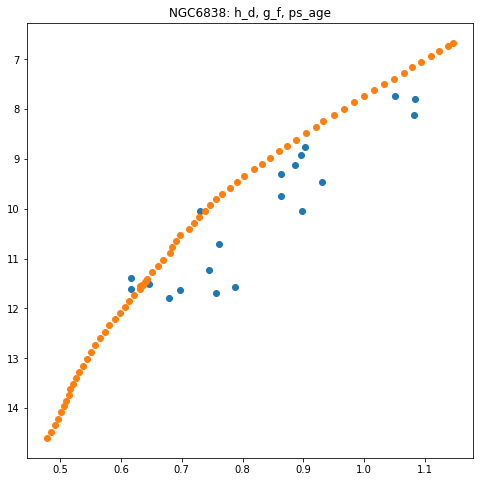

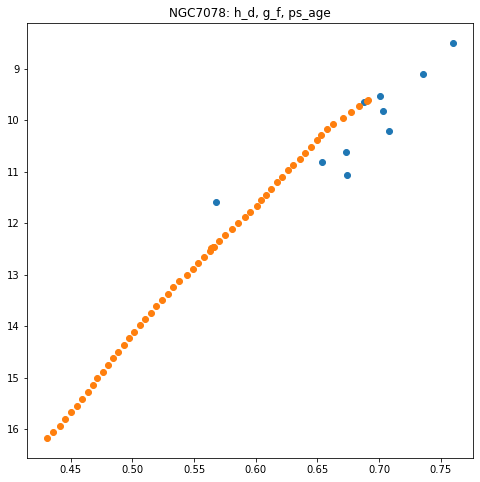

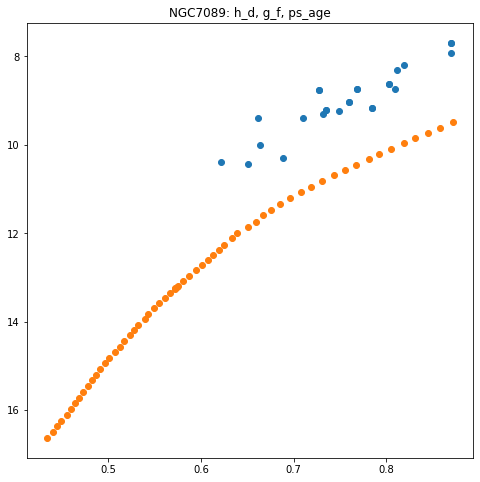

In [62]:
for i in range(len(supp2)):
    plt.figure(figsize=[8,8])
    clus = np.where(ngc_names==supp2['Cluster'][i])

    plt.scatter((gcs['J']-gcs['K'])[clus],gcs['K'][clus]-test_ak[i])
    plt.scatter(lits_isos[i]['Jmag']-lits_isos[i]['Ksmag'],lits_isos[i]['Ksmag']+dismod1[i]-test_ejk[i])
    
    plt.gca().invert_yaxis()
    
    plt.title(r'{}: h_d, g_f, ps_age'.format(supp2['Cluster'][i]))
    
    plt.show()